# Airport flights delays


## Scenario

The study aims at analysing the operations of major airports around the country. The idea behind,is to improve the service quality and notably cut down on delays nationwide. The most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

To that extent, we're going to be using three different datasets related to airport operations. These include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

As per information,when a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay.Also, at the end of the year, this data is averaged out for each airport. The datasets have these averaged for a 10 year range between 2004 and 2014

We will then process as follow:

- Organize and store their data so that it can be easily understanded;
- Mine and refine the data to uncover its basic attributes and characteristics
- Use PCA and clustering methods to uncover the core components of operations related to delays.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk 
import psycopg2 as psy
from sqlalchemy import create_engine
from __future__ import division

In [106]:
df_raw = pd.read_csv("../../../DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/airport_cancellations.csv")
df = df_raw.dropna() 
print df.head()

  Airport    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   

   Departure Diversions  Arrival Diversions  
0                  71.0                46.0  
1                  61.0                33.0  
2                  71.0               124.0  
3                 107.0                45.0  
4                  79.0                42.0  


In [107]:
df2_raw = pd.read_csv("../../../DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/Airport_operations.csv")
df2 = df2_raw.dropna() 
print df2.head()

  airport  year  departures for metric computation  \
0     ABQ  2004                              53971   
1     ABQ  2005                              51829   
2     ABQ  2006                              49682   
3     ABQ  2007                              53255   
4     ABQ  2008                              49589   

   arrivals for metric computation  percent on-time gate departures  \
0                            53818                           0.8030   
1                            51877                           0.8140   
2                            51199                           0.7983   
3                            53611                           0.8005   
4                            49512                           0.8103   

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   
2                              0

In [108]:

df3_raw = pd.read_csv("../../../DSI_LDN_1_LESSON_NOTES/projects/project-07/assets/airports.csv")
df3 = df3_raw.dropna() 
print df3.head()

      Key LocID                   AP_NAME  \
0  3443.0   STX           HENRY E ROHLSEN   
2  2886.0   PSE                 MERCEDITA   
3  2879.0   VQS  ANTONIO RIVERA RODRIGUEZ   
4  2883.0   X63                   HUMACAO   
5  2884.0   RVR   JOSE APONTE DE LA TORRE   

                                 ALIAS Facility Type FAA REGION  \
0        Henry E Rohlsen Int'l Airport       Airport        ASO   
2                 Aeropuerto Mercedita       Airport        ASO   
3  Aeropuerto Antonio Rivera Rodr�guez       Airport        ASO   
4       Aeropuerto Regional De Humacao       Airport        ASO   
5   Aeropuerto Jos� Aponte De La Torre       Airport        ASO   

             COUNTY             CITY STATE     AP Type   Latitude  Longitude  \
0  -VIRGIN ISLANDS-    CHRISTIANSTED    VI  Public Use  17.701556 -64.801722   
2            #NAME?            PONCE    PR  Public Use  18.008306 -66.563028   
3            #NAME?  ISLA DE VIEQUES    PR  Public Use  18.134811 -65.493617   
4     

#### Let's create a database where we can house our airport data

In [109]:
%load_ext sql
from sqlalchemy import create_engine

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [110]:
engine=create_engine('postgresql://localhost:5432/airport_info')
conn=engine.connect()

Load our csv files into tables

In [111]:
df.to_sql('cancelation',con=conn)
df2.to_sql('operation',con=conn)
df3.to_sql('airport',con=conn)


Join airport_cancellations.csv and airports.csv into one table

In [112]:
%%sql postgresql://localhost:5432/airport_info


select * from operation limit 5;

5 rows affected.


index,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.6,9.79,2.29,11.2,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.4,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [113]:
%%sql

select * from cancelation limit 5;

5 rows affected.


index,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [114]:
%%sql

select * from airport limit 5;

5 rows affected.


index,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes
5,2884.0,RVR,JOSE APONTE DE LA TORRE,Aeropuerto Jos� Aponte De La Torre,Airport,ASO,#NAME?,CEIBA,PR,Public Use,18.245269,-65.643381,Yes


In [115]:
# we can join airport and cancelation on LocID and airport column BUT WE NEED FIRST TO DROP INDEX COLUMN IN EACH

In [116]:
%%sql

ALTER TABLE airport
DROP "index";

Done.


[]

In [117]:
%%sql

ALTER TABLE cancelation
DROP "index";

Done.


[]

In [118]:
%%sql

ALTER TABLE operation
DROP "index";

Done.


[]

In [120]:
%%sql
CREATE TABLE airport_final
AS (SELECT * from operation AO
    INNER JOIN cancelation AC ON (AC."Airport"=AO."airport" and AC."Year"=AO."year")
    INNER JOIN airport A ON A."LocID"=AC."Airport");

799 rows affected.


[]

Query the database for our intial data

In [121]:
conn=psy.connect(host="localhost",port=5432,user='dorian',database='airport_info')
cur=conn.cursor()
cur.execute("SELECT * FROM airport_final limit 5;")
ap = cur.fetchall()
print ap

[('SJU', 2014L, 43671L, 42965L, 0.8056, 0.7784, 0.7815, 11.71, 12.89, 1.88, 13.13, 1.81, 1.0, 2.93, 12.79, 'SJU', 2014.0, 280.0, 241.0, 72.0, 31.0, 2885.0, 'SJU', 'LUIS MUNOZ MARIN INTL', "Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", 'Airport', 'ASO', '#NAME?', 'SAN JUAN', 'PR', 'Federalized/Commercial', 18.439295, -66.002004, 'Yes'), ('SJU', 2013L, 42902L, 42175L, 0.8058, 0.7808, 0.784, 12.31, 13.56, 2.2, 13.52, 1.78, 1.41, 2.86, 12.96, 'SJU', 2013.0, 127.0, 94.0, 65.0, 64.0, 2885.0, 'SJU', 'LUIS MUNOZ MARIN INTL', "Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", 'Airport', 'ASO', '#NAME?', 'SAN JUAN', 'PR', 'Federalized/Commercial', 18.439295, -66.002004, 'Yes'), ('SJU', 2012L, 44716L, 43985L, 0.8417, 0.8228, 0.8181, 9.55, 13.15, 1.82, 10.55, 1.41, 1.33, 2.89, 10.64, 'SJU', 2012.0, 174.0, 141.0, 62.0, 41.0, 2885.0, 'SJU', 'LUIS MUNOZ MARIN INTL', "Aeropuerto Int'l Luis Mu\xef\xbf\xbdoz Marin", 'Airport', 'ASO', '#NAME?', 'SAN JUAN', 'PR', 'Federalized/Commercial', 18.439295, -66.002

In [122]:
cur.close()
conn.close()

In [ ]:
engine=create_engine('postgresql://localhost:5432/airport_info')
conn=engine.connect()

In [144]:
%%sql

ALTER TABLE airport_final DROP COLUMN "Year", DROP COLUMN "Airport", DROP COLUMN "LocID";

Done.


[]

In [145]:
pd.set_option("display.max_columns",200)
query= %%sql select * from airport_final;

ap=query.DataFrame()
ap.head()

799 rows affected.


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,SJU,2014,43671,42965,0.8056,0.7784,0.7815,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,280.0,241.0,72.0,31.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
1,SJU,2013,42902,42175,0.8058,0.7808,0.7840,12.31,13.56,2.20,13.52,1.78,1.41,2.86,12.96,127.0,94.0,65.0,64.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
2,SJU,2012,44716,43985,0.8417,0.8228,0.8181,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64,174.0,141.0,62.0,41.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
3,SJU,2011,42803,42401,0.8179,0.7934,0.7899,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28,240.0,201.0,101.0,55.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
4,SJU,2010,47314,45781,0.7967,0.7815,0.7719,12.21,13.04,1.39,13.00,1.65,1.32,3.53,13.40,258.0,207.0,82.0,45.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes


#### Risks and assumptions of our data? 

We need to check missing value. Also much data represent an average all over the year, which might not be highlight some peak period that could create problems.

### Exploratory Data Analysis

In [2]:
engine=create_engine('postgresql://localhost:5432/airport_info')
conn=engine.connect()
pd.set_option("display.max_columns",200)

In [3]:
%load_ext sql

In [4]:
%%sql postgresql://localhost:5432/airport_info
        
select * from airport_final limit 5;

5 rows affected.


airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
SJU,2014,43671,42965,0.8056,0.7784,0.7815,11.71,12.89,1.88,13.13,1.81,1.0,2.93,12.79,280.0,241.0,72.0,31.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
SJU,2013,42902,42175,0.8058,0.7808,0.784,12.31,13.56,2.2,13.52,1.78,1.41,2.86,12.96,127.0,94.0,65.0,64.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
SJU,2012,44716,43985,0.8417,0.8228,0.8181,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64,174.0,141.0,62.0,41.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
SJU,2011,42803,42401,0.8179,0.7934,0.7899,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28,240.0,201.0,101.0,55.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes
SJU,2010,47314,45781,0.7967,0.7815,0.7719,12.21,13.04,1.39,13.0,1.65,1.32,3.53,13.4,258.0,207.0,82.0,45.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes


In [5]:
query= %%sql select * from airport_final;
ap=query.DataFrame()
ap.head()
ap.describe()

799 rows affected.


,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,Latitude,Longitude
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,2009.016270,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811,1299.314143,1341.068836,174.250313,170.256571,1714.484355,36.448807,-94.899998
std,3.150126,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647,1840.877193,1980.459892,172.638408,229.162686,1005.059201,6.686781,20.644996
min,2004.000000,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000,0.000000,0.000000,0.000000,0.000000,246.000000,18.439295,-157.922429
25%,2006.000000,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000,349.000000,314.500000,62.000000,41.000000,770.000000,32.896828,-111.977773
50%,2009.000000,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000,670.000000,653.000000,111.000000,84.000000,1531.000000,37.618972,-87.897068
75%,2012.000000,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000,1483.500000,1542.000000,237.000000,190.000000,2502.000000,40.795250,-80.152741
max,2014.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000,16618.000000,17571.000000,1064.000000,1948.000000,3575.000000,61.174083,-66.002004


In [6]:
#how many airport + airport by FAA REGION (margin_true)

group1=ap.groupby(["FAA REGION"])["airport"].nunique().sort_values(ascending=False)
group1["Number of airports"]=sum(group1.values)
print group1

FAA REGION
AWP                   17
ASO                   16
AEA                   12
AGL                    9
ASW                    8
ANM                    4
ANE                    4
ACE                    3
AAL                    1
Number of airports    74
Name: airport, dtype: int64


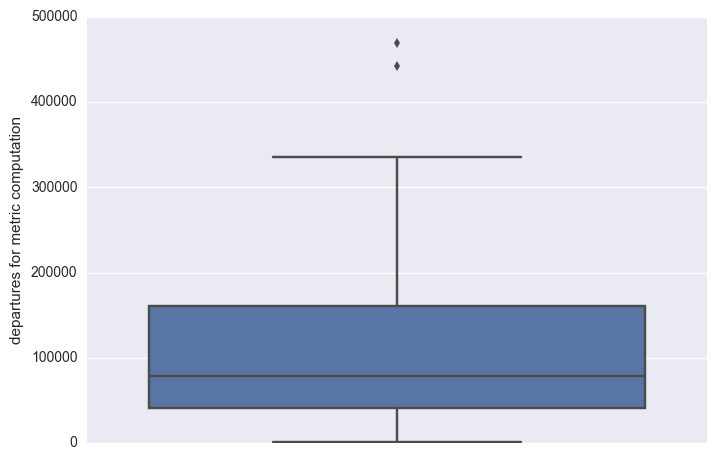

For this project, we will consider an aiport with 'low' flights frequency when average departure are below 41199 a year.
 At contrary, any airport with flights average departure over 160396 a year will consider as 'high' flights frequency and the other as 'medium flighs frequency
We are avoiding here the possibility of an airport to change start over the year which can sometimes not reflect the reality


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#boxplot on number of arrival, dep
#create qualif [small, medium size, big][1-2-3]

pivot1=pd.pivot_table(ap, index=["airport"], \
                      values=["departures for metric computation","arrivals for metric computation"],\
                      aggfunc=(np.mean))
pivot1=pivot1.sort_values(by=['departures for metric computation',"arrivals for metric computation"],ascending=False)
sns.boxplot(y=pivot1["departures for metric computation"])
plt.show()

lower_quartile=np.percentile(pivot1["departures for metric computation"],25)
upper_quartile=np.percentile(pivot1["departures for metric computation"],75)

print "For this project, we will consider an aiport with 'low' flights frequency when average departure are below %d a year.\n \
At contrary, any airport with flights average departure over %d a year will consider as 'high' flights frequency and the other as 'medium flighs frequency"\
%(int(lower_quartile),int(upper_quartile))
print "We are avoiding here the possibility of an airport to change start over the year which can sometimes not reflect the reality"

In [8]:
# we're here qualificating the airport , 0 to small , 1 to medium and 2 to high frequency flight.
def qualification(row):
    result=1
    if row <=lower_quartile:
        result=0
    elif row >= upper_quartile:
        result=2
    return result
        

pivot1["airport_qualification"]=pivot1["departures for metric computation"].apply(qualification)
pivot1.head()

,arrivals for metric computation,departures for metric computation,airport_qualification
airport,,,
ATL,465716.909091,469004.000000,2
ORD,442203.545455,441830.909091,2
DFW,334805.636364,335741.727273,2
DEN,296575.090909,297644.454545,2
LAX,293183.272727,293085.545455,2


In [9]:
#let's compute it in our main dataset
dic_qualification=pivot1["airport_qualification"].to_dict()

ap["airport_qualification"]=ap["airport"].map(dic_qualification)
ap.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,Key,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available,airport_qualification
0,SJU,2014,43671,42965,0.8056,0.7784,0.7815,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,280.0,241.0,72.0,31.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,1
1,SJU,2013,42902,42175,0.8058,0.7808,0.7840,12.31,13.56,2.20,13.52,1.78,1.41,2.86,12.96,127.0,94.0,65.0,64.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,1
2,SJU,2012,44716,43985,0.8417,0.8228,0.8181,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64,174.0,141.0,62.0,41.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,1
3,SJU,2011,42803,42401,0.8179,0.7934,0.7899,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28,240.0,201.0,101.0,55.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,1
4,SJU,2010,47314,45781,0.7967,0.7815,0.7719,12.21,13.04,1.39,13.00,1.65,1.32,3.53,13.40,258.0,207.0,82.0,45.0,2885.0,LUIS MUNOZ MARIN INTL,Aeropuerto Int'l Luis Mu�oz Marin,Airport,ASO,#NAME?,SAN JUAN,PR,Federalized/Commercial,18.439295,-66.002004,Yes,1


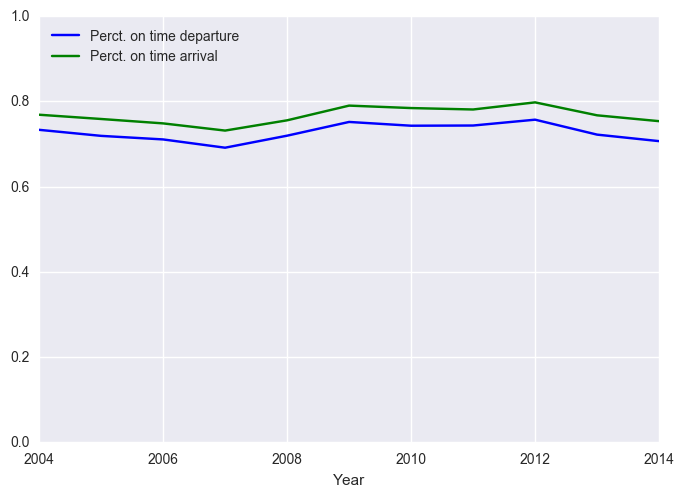

In [10]:
# is the delay improving all over the year?

group2=ap.groupby(["year"])["percent on-time airport departures","percent on-time gate arrivals"].mean()

plt.plot(list(group2.index),group2["percent on-time airport departures"],c="b",label="Perct. on time departure")
plt.plot(list(group2.index),group2["percent on-time gate arrivals"],c="g",label="Perct. on time arrival")
plt.xlabel("Year")
plt.legend(loc=2)
plt.ylim(0.0,1)
plt.show()

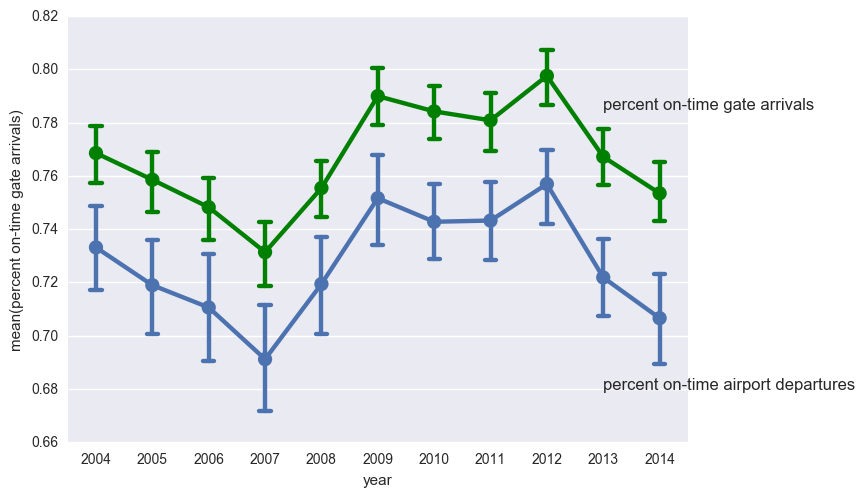

In [11]:
#in more detail
sns.pointplot(x="year", y="percent on-time airport departures", data=ap, estimator=np.mean, capsize=.2)
sns.pointplot(x="year", y="percent on-time gate arrivals", data=ap, estimator=np.mean, capsize=.2, color="green")
plt.annotate("percent on-time gate arrivals", (9,0.785))
plt.annotate("percent on-time airport departures", (9,0.68))
plt.show()

The delay stay  flat between 20% to 30% on departure and arrival flight which is a lot!.
What is worrying is that we can see any improvement over the year, otherwise a desengagement in the services provided...
Is it because airports faced to an overwherlming increase of flights over the year?

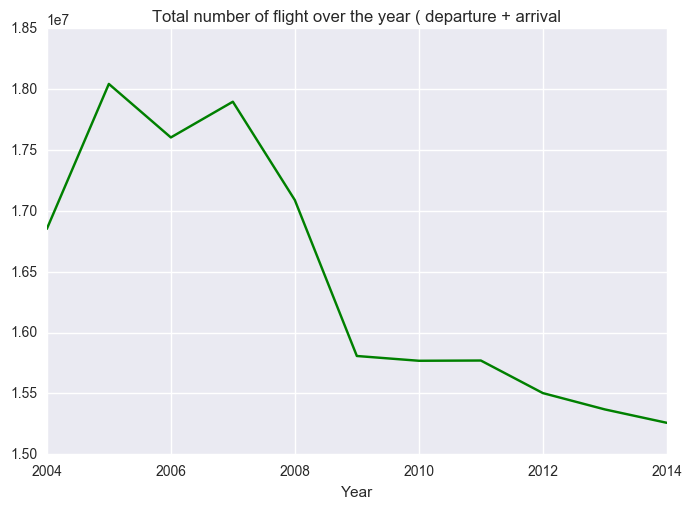

In [12]:
group3=ap.groupby(["year"])["departures for metric computation","arrivals for metric computation"].sum()

plt.plot(list(group3.index),group3["departures for metric computation"]+ group3["arrivals for metric computation"],c="g")
plt.xlabel("Year")
plt.title("Total number of flight over the year ( departure + arrival")
plt.show()

In [13]:

decrease= 1- (group3.loc[2014,"departures for metric computation"] +group3.loc[2014,"arrivals for metric computation"])\
/(group3.loc[2005,"departures for metric computation"] +group3.loc[2005,"arrivals for metric computation"])
print "Wow, no increase at all! There is even a decrease of %d %% of flights flow in 10 years!\n\
What is the reason for the decrease of the quality then?"%(round(100*decrease,0))

Wow, no increase at all! There is even a decrease of 15 % of flights flow in 10 years!
What is the reason for the decrease of the quality then?


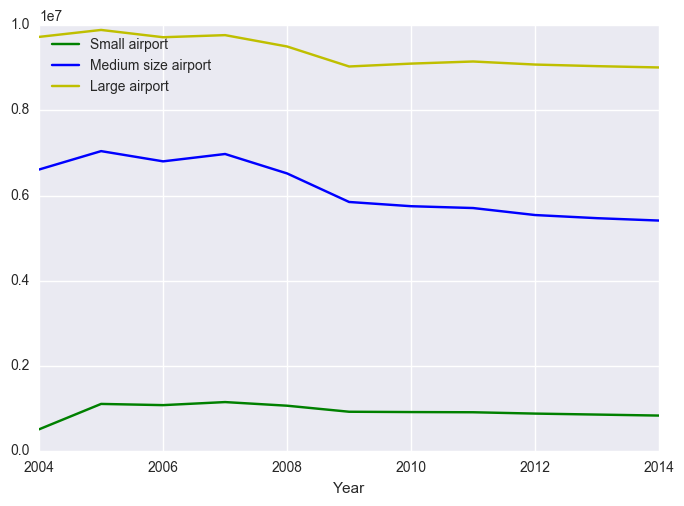

In [14]:
group4=ap.groupby(["airport_qualification","year"])["departures for metric computation","arrivals for metric computation"].sum()



plt.plot(list(group4.loc[0,:].index),group4.loc[0,"departures for metric computation"]+ group4.loc[0,"arrivals for metric computation"],label="Small airport",c="g")
plt.plot(list(group4.loc[0,:].index),group4.loc[1,"departures for metric computation"]+ group4.loc[1,"arrivals for metric computation"],label="Medium size airport",c="b")
plt.plot(list(group4.loc[0,:].index),group4.loc[2,"departures for metric computation"]+ group4.loc[2,"arrivals for metric computation"],label="Large airport",c="y")
plt.xlabel("Year")
plt.legend(loc=2)
plt.show()

There were no shift of activity from one tipe of airport to another which could explain the bad delay result.

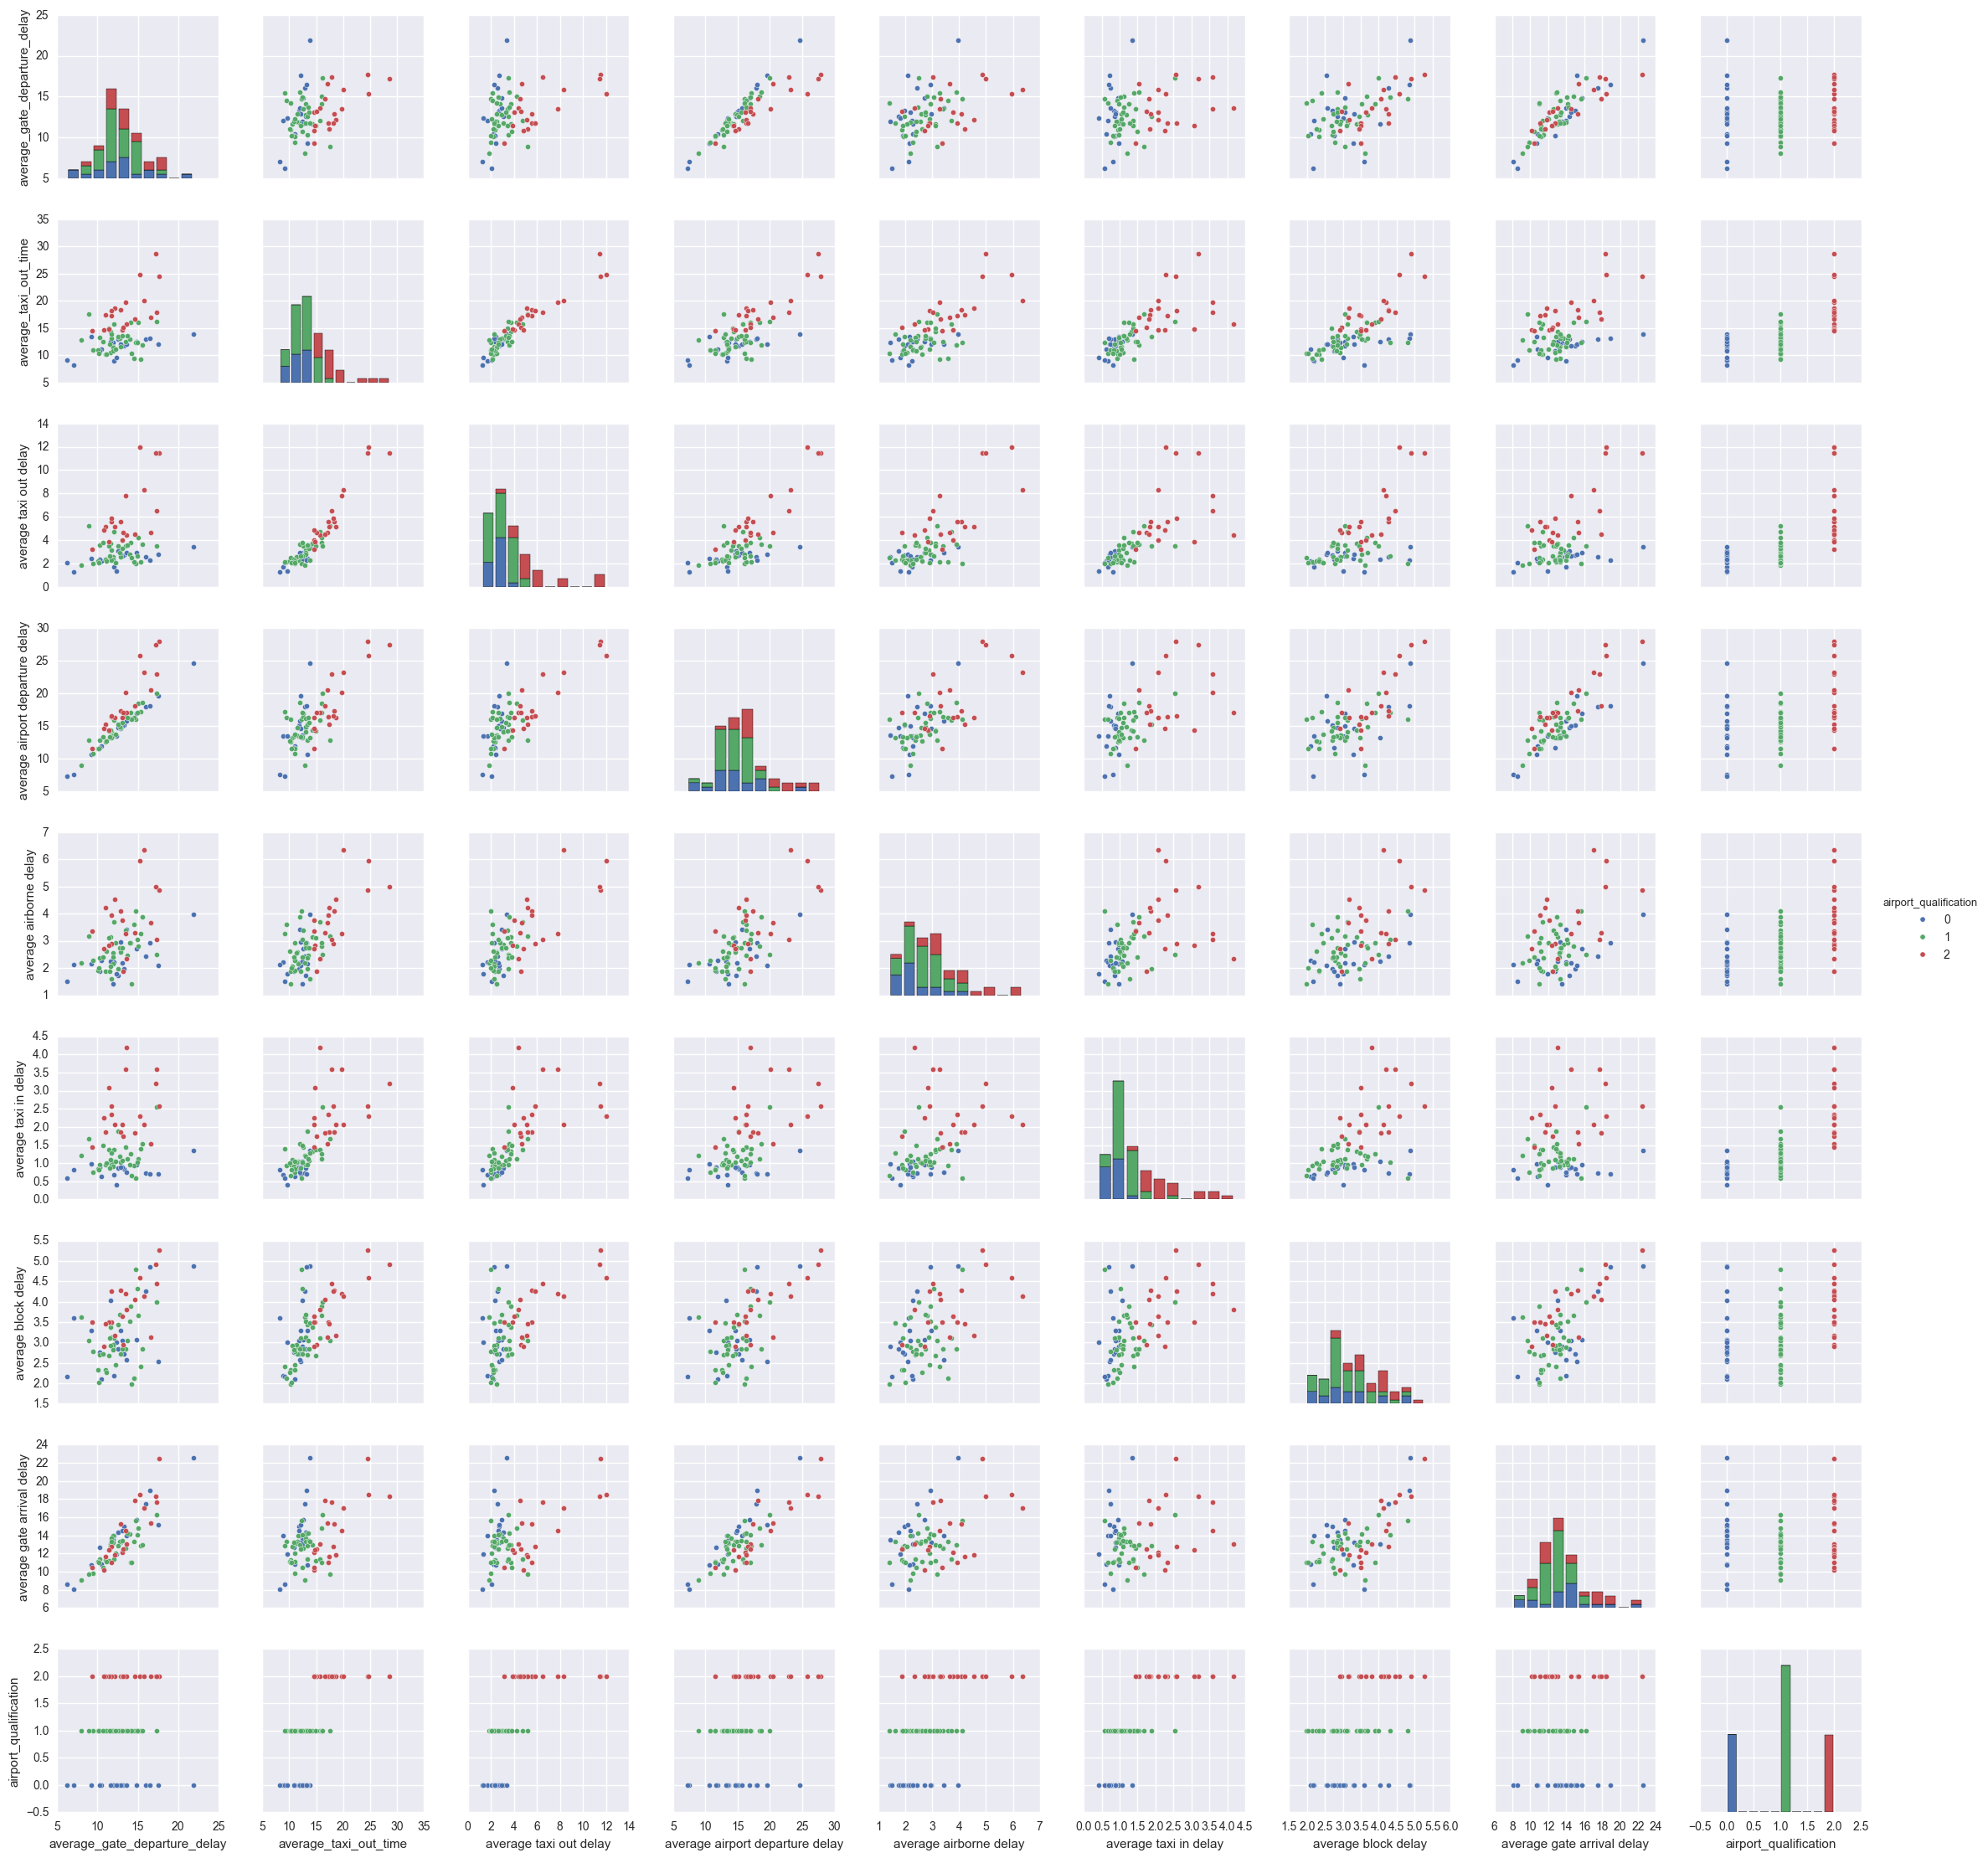

In [15]:
#What cause delays
#who are the worst airport?
delay=ap.columns[7:15].tolist()
delay.append("airport_qualification")
group5=ap.groupby(["airport"])[delay].mean()

sns.pairplot(data=group5,
             hue="airport_qualification", dropna=True)
plt.show()

Interestingly we notice some correlation between delays, one engendering another!
Also we can seesome cluster (by class of airport) as per exemple of the taxi delay, which is important for big airport but other not, which is where it is interesting to have a looking and find a cluster that does not refers to the airport size.

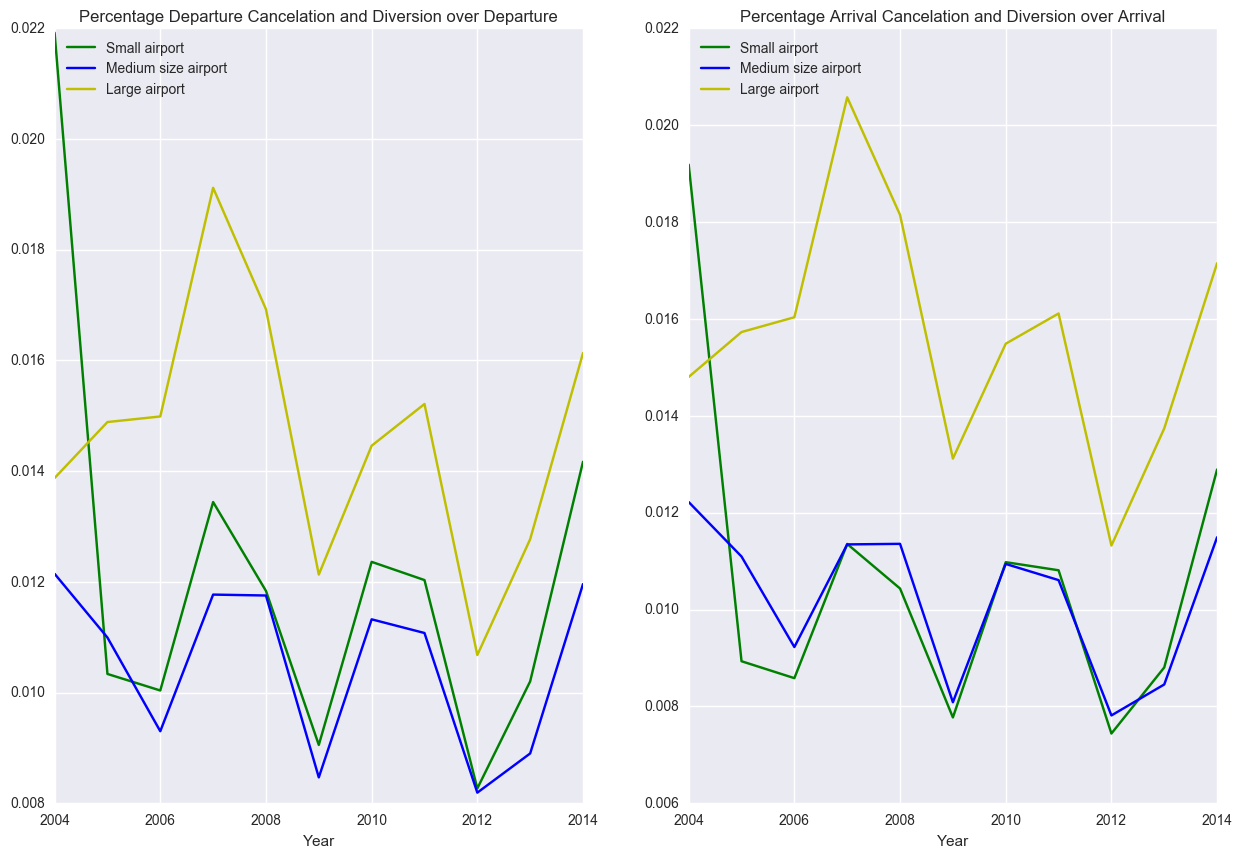

In [16]:
# how about Cancelation +diversion (pair grid dot plot
cancelation=["airport_qualification", 'Departure Cancellations', 'Arrival Cancellations','Departure Diversions','Arrival Diversions']
group6=ap.groupby(["airport_qualification","year"])[cancelation[1:]].mean()

group6B=ap.groupby(["airport_qualification","year"])["departures for metric computation","arrivals for metric computation"].mean()

fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.plot(list(group6.loc[0,:].index),(group6.loc[0,cancelation[1]]+group6.loc[0,cancelation[3]])/group6B.loc[0,"departures for metric computation"],label="Small airport",c="g")
ax1.plot(list(group6.loc[0,:].index),(group6.loc[1,cancelation[1]]+group6.loc[1,cancelation[3]])/group6B.loc[1,"departures for metric computation"],label="Medium size airport",c="b")
ax1.plot(list(group6.loc[0,:].index),(group6.loc[2,cancelation[1]]+group6.loc[2,cancelation[3]])/group6B.loc[2,"departures for metric computation"],label="Large airport",c="y")
ax1.set_title("Percentage Departure Cancelation and Diversion over Departure")
ax1.set_xlabel("Year")
ax1.legend(loc=2)

ax2.plot(list(group6.loc[0,:].index),(group6.loc[0,cancelation[2]]+group6.loc[0,cancelation[4]])/group6B.loc[0,"arrivals for metric computation"],label="Small airport",c="g")
ax2.plot(list(group6.loc[0,:].index),(group6.loc[1,cancelation[2]]+group6.loc[1,cancelation[4]])/group6B.loc[1,"arrivals for metric computation"],label="Medium size airport",c="b")
ax2.plot(list(group6.loc[0,:].index),(group6.loc[2,cancelation[2]]+group6.loc[2,cancelation[4]])/group6B.loc[2,"arrivals for metric computation"],label="Large airport",c="y")
ax2.set_title("Percentage Arrival Cancelation and Diversion over Arrival")
ax2.set_xlabel("Year")
ax2.legend(loc=2)

plt.show()


At a same scale, we can see that large airport faced mode cancelation and diversion although it stay below 2%, again, as for the delays there were an augmentation of cancelations and diversions.

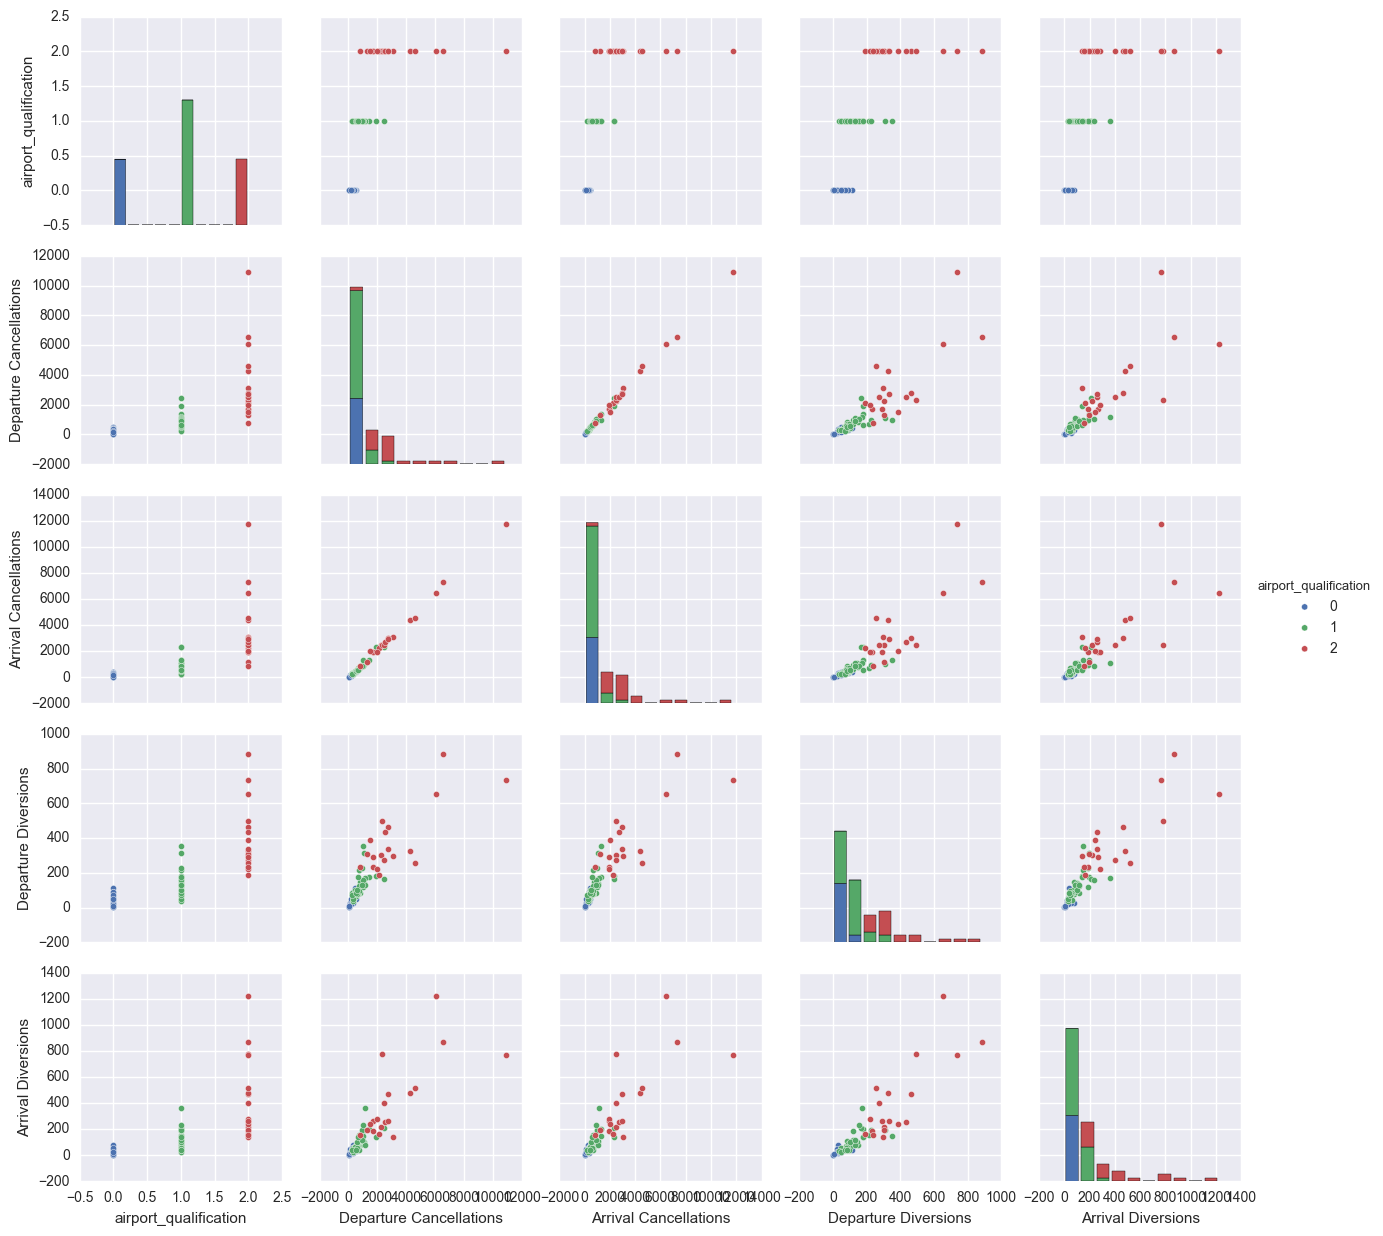

In [17]:

group7=ap.groupby(["airport"])[cancelation].mean()

sns.pairplot(data=group7,
             hue="airport_qualification", dropna=True)
plt.show()

Departure and arrival cancelation seems to be almost perfectly correlated which makes sence.


#### Are there any unique values? 

In [18]:
import numpy as np

In [19]:
unique=ap.apply(lambda x: len(np.unique(x)))
unique.sort_values()[:10]

Facility Type               1
Boundary Data Available     1
AP Type                     2
airport_qualification       3
FAA REGION                  9
year                       11
STATE                      36
COUNTY                     63
CITY                       69
Longitude                  74
dtype: int64

Boundary Data available and Facility type are of course to be delete. 
Otherwise unique values are related to location information about the 74 airports.

In [20]:
#missing_val?
print ap.isnull().sum()
print "no missing value"

airport                               0
year                                  0
departures for metric computation     0
arrivals for metric computation       0
percent on-time gate departures       0
percent on-time airport departures    0
percent on-time gate arrivals         0
average_gate_departure_delay          0
average_taxi_out_time                 0
average taxi out delay                0
average airport departure delay       0
average airborne delay                0
average taxi in delay                 0
average block delay                   0
average gate arrival delay            0
Departure Cancellations               0
Arrival Cancellations                 0
Departure Diversions                  0
Arrival Diversions                    0
Key                                   0
AP_NAME                               0
ALIAS                                 0
Facility Type                         0
FAA REGION                            0
COUNTY                                0


In [21]:
#deleting unecessary columns
to_delete=["Boundary Data Available","Facility Type","COUNTY","STATE","CITY","Key","ALIAS","AP_NAME"]

for col in to_delete:
    del ap[col]

ap.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,FAA REGION,AP Type,Latitude,Longitude,airport_qualification
0,SJU,2014,43671,42965,0.8056,0.7784,0.7815,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,280.0,241.0,72.0,31.0,ASO,Federalized/Commercial,18.439295,-66.002004,1
1,SJU,2013,42902,42175,0.8058,0.7808,0.7840,12.31,13.56,2.20,13.52,1.78,1.41,2.86,12.96,127.0,94.0,65.0,64.0,ASO,Federalized/Commercial,18.439295,-66.002004,1
2,SJU,2012,44716,43985,0.8417,0.8228,0.8181,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64,174.0,141.0,62.0,41.0,ASO,Federalized/Commercial,18.439295,-66.002004,1
3,SJU,2011,42803,42401,0.8179,0.7934,0.7899,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28,240.0,201.0,101.0,55.0,ASO,Federalized/Commercial,18.439295,-66.002004,1
4,SJU,2010,47314,45781,0.7967,0.7815,0.7719,12.21,13.04,1.39,13.00,1.65,1.32,3.53,13.40,258.0,207.0,82.0,45.0,ASO,Federalized/Commercial,18.439295,-66.002004,1


### Data Mining

In [22]:
# I'll label text data.
from sklearn.preprocessing import LabelEncoder 
    
faa_region=list(ap["FAA REGION"].unique())
ap_type=list(ap["AP Type"].unique())

lb1=LabelEncoder()
lb1.fit(faa_region)
ap["FAA REGION"]=lb1.transform(ap["FAA REGION"])

lb2=LabelEncoder()
lb2.fit(ap_type)
ap["AP Type"]=lb2.transform(ap["AP Type"])

ap.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions,FAA REGION,AP Type,Latitude,Longitude,airport_qualification
0,SJU,2014,43671,42965,0.8056,0.7784,0.7815,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,280.0,241.0,72.0,31.0,6,0,18.439295,-66.002004,1
1,SJU,2013,42902,42175,0.8058,0.7808,0.7840,12.31,13.56,2.20,13.52,1.78,1.41,2.86,12.96,127.0,94.0,65.0,64.0,6,0,18.439295,-66.002004,1
2,SJU,2012,44716,43985,0.8417,0.8228,0.8181,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64,174.0,141.0,62.0,41.0,6,0,18.439295,-66.002004,1
3,SJU,2011,42803,42401,0.8179,0.7934,0.7899,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28,240.0,201.0,101.0,55.0,6,0,18.439295,-66.002004,1
4,SJU,2010,47314,45781,0.7967,0.7815,0.7719,12.21,13.04,1.39,13.00,1.65,1.32,3.53,13.40,258.0,207.0,82.0,45.0,6,0,18.439295,-66.002004,1


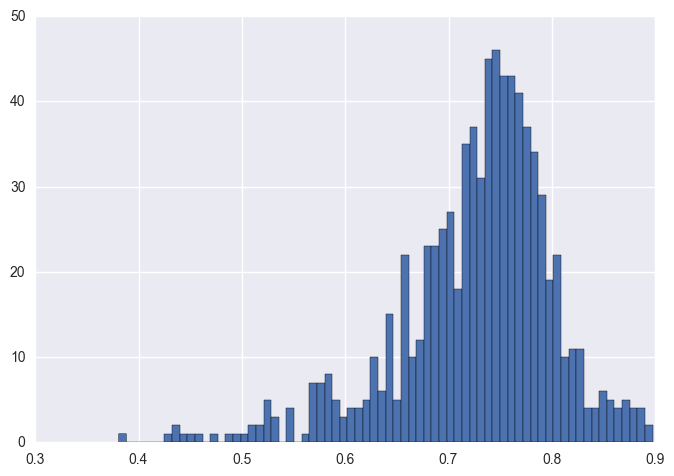

In [26]:
# Our dataset has a normal distribution

ap["percent on-time airport departures"].hist(bins=70)
plt.show()

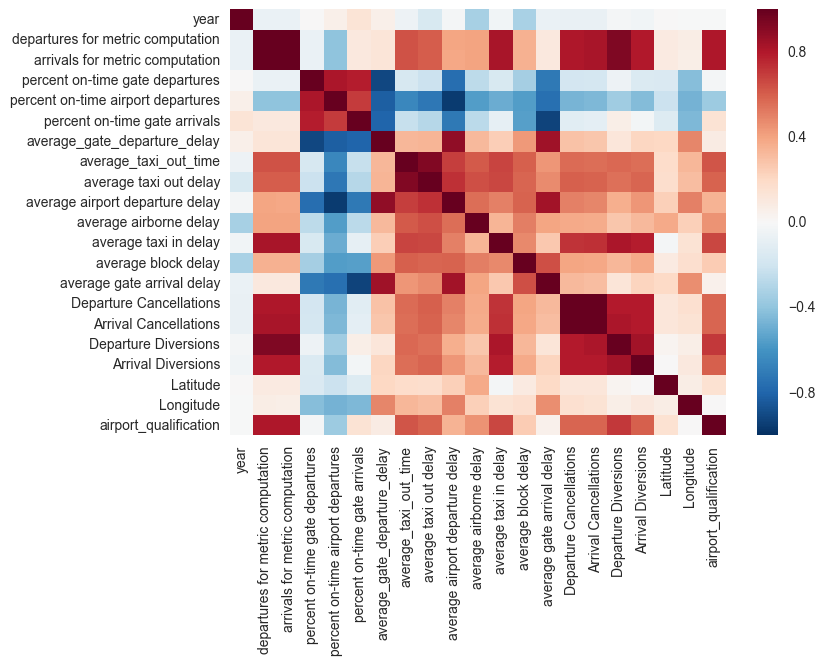

In [26]:
# on top of what we analysed above, we can have a look at the heatmap
sns.heatmap(ap.corr())
plt.show()

The pearson correlation coefficitient gives us a good idea of how is the linear dependence between two features.


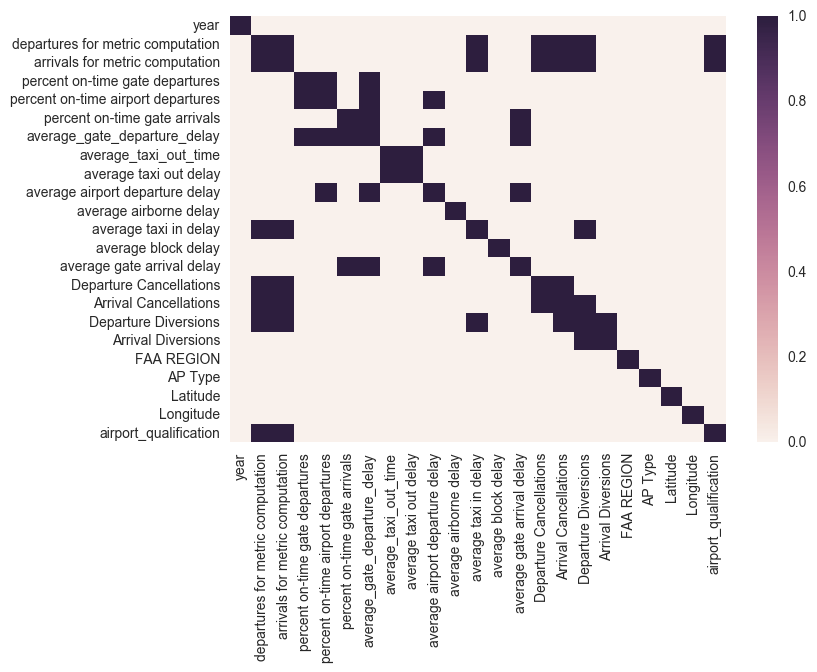

In [37]:
#let's consider correlated when the pearson coefficient is above 0.8
correlation=np.absolute(ap.corr()) >=0.8
sns.heatmap(correlation)
plt.show()

### Let's now Perform a PCA 

In [113]:
# Create a clean data frame and looking at the delays
ap1 = ap.iloc[:,7:15]
ap1.head()

,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79
1,12.31,13.56,2.20,13.52,1.78,1.41,2.86,12.96
2,9.55,13.15,1.82,10.55,1.41,1.33,2.89,10.64
3,10.86,13.23,1.96,12.07,1.45,1.57,3.67,12.28
4,12.21,13.04,1.39,13.00,1.65,1.32,3.53,13.40


In [114]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

In [115]:
# let's apply a principal componant analysis on the airport dataset, including the classification we made without FAA.
pca = PCA()
Xt=StandardScaler().fit_transform(ap1)
pca.fit(Xt)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [116]:
#eigen values and eigen vectors
eigenval=pca.explained_variance_
exp_var=pca.explained_variance_ratio_
eigenvec=pca.components_

In [117]:
exp_var

array([  6.19126702e-01,   1.72814351e-01,   8.15075424e-02,
         6.43750430e-02,   3.88833953e-02,   1.35572069e-02,
         9.58513086e-03,   1.50628291e-04])

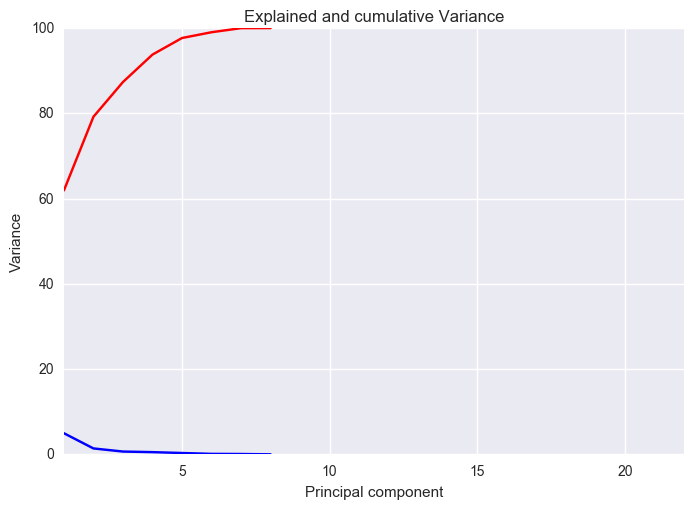

In [119]:
#ploting the variance (eigenvalues) and cumulative variance
cum_var_exp=np.cumsum(eigenval)*100/sum(eigenval)
plt.plot(range(1,len(eigenval)+1),eigenval, c='b')
plt.plot(range(1,len(eigenval)+1),cum_var_exp, c='r')
plt.title("Explained and cumulative Variance")
plt.xlabel('Principal component')
plt.ylabel('Variance')
plt.xlim((1,22))
plt.show()

We notice that 2 principal components represent 80%, we'll then reduce the study to those 2 components 

       PCA1      PCA2
0 -1.391381 -0.259948
1 -1.042859 -0.128754
2 -2.087993  0.684603
3 -1.229050  0.279229
4 -1.073065 -0.360846


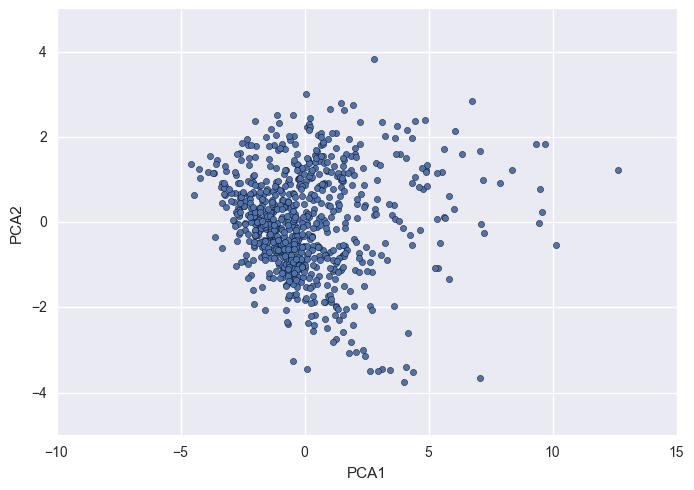

In [127]:
pca=PCA(n_components=2)
pca.fit(Xt)
Xred=pd.DataFrame(pca.transform(Xt), columns=['PCA1', 'PCA2'])
print Xred.head()

Xred.plot.scatter("PCA1","PCA2")
plt.show()

I will now try to highlight some cluster in term of airports.

In [128]:
# as we can see there is a lot of density in a same area, let's start by using density based clustering and try to highlight cluster!


from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

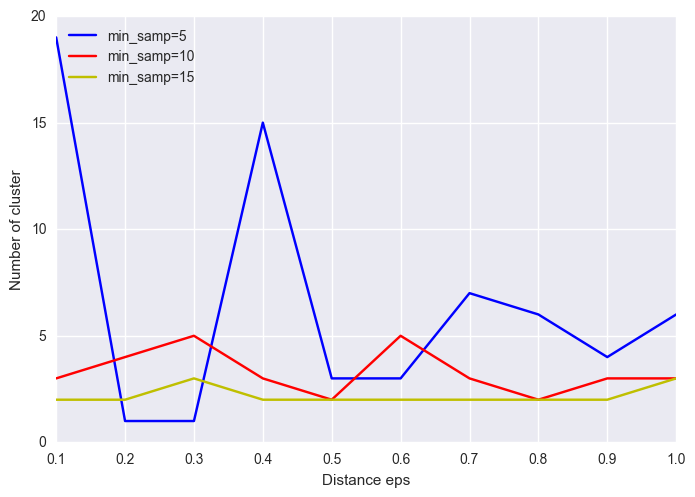

In [135]:
# plot the evolution of number of cluster in functions of the distance n and the minimum number per cluster

eps=[0.1*x for x in range(1,11)]
min_samp=[5,10,15]

num_cluster=[]

for d in eps:
    for samp in min_samp:
        db=DBSCAN(eps=d,min_samples=samp)
        db.fit(Xred)
        num_cluster.append(len(np.unique(db.labels_)))

plt.plot(eps,num_cluster[:10],c="b",label="min_samp=5")
plt.plot(eps,num_cluster[10:20],c="r",label="min_samp=10")
plt.plot(eps,num_cluster[20:30],c="y",label="min_samp=15")
plt.xlabel("Distance eps")
plt.ylabel("Number of cluster")
plt.legend(loc=2)
plt.show()


In [141]:
#if we look at hierarchical clustering

Z = linkage(Xred, 'ward')
c, coph_dists = cophenet(Z, pdist(Xred))

 Cophenit coefficient: 0.664658250977


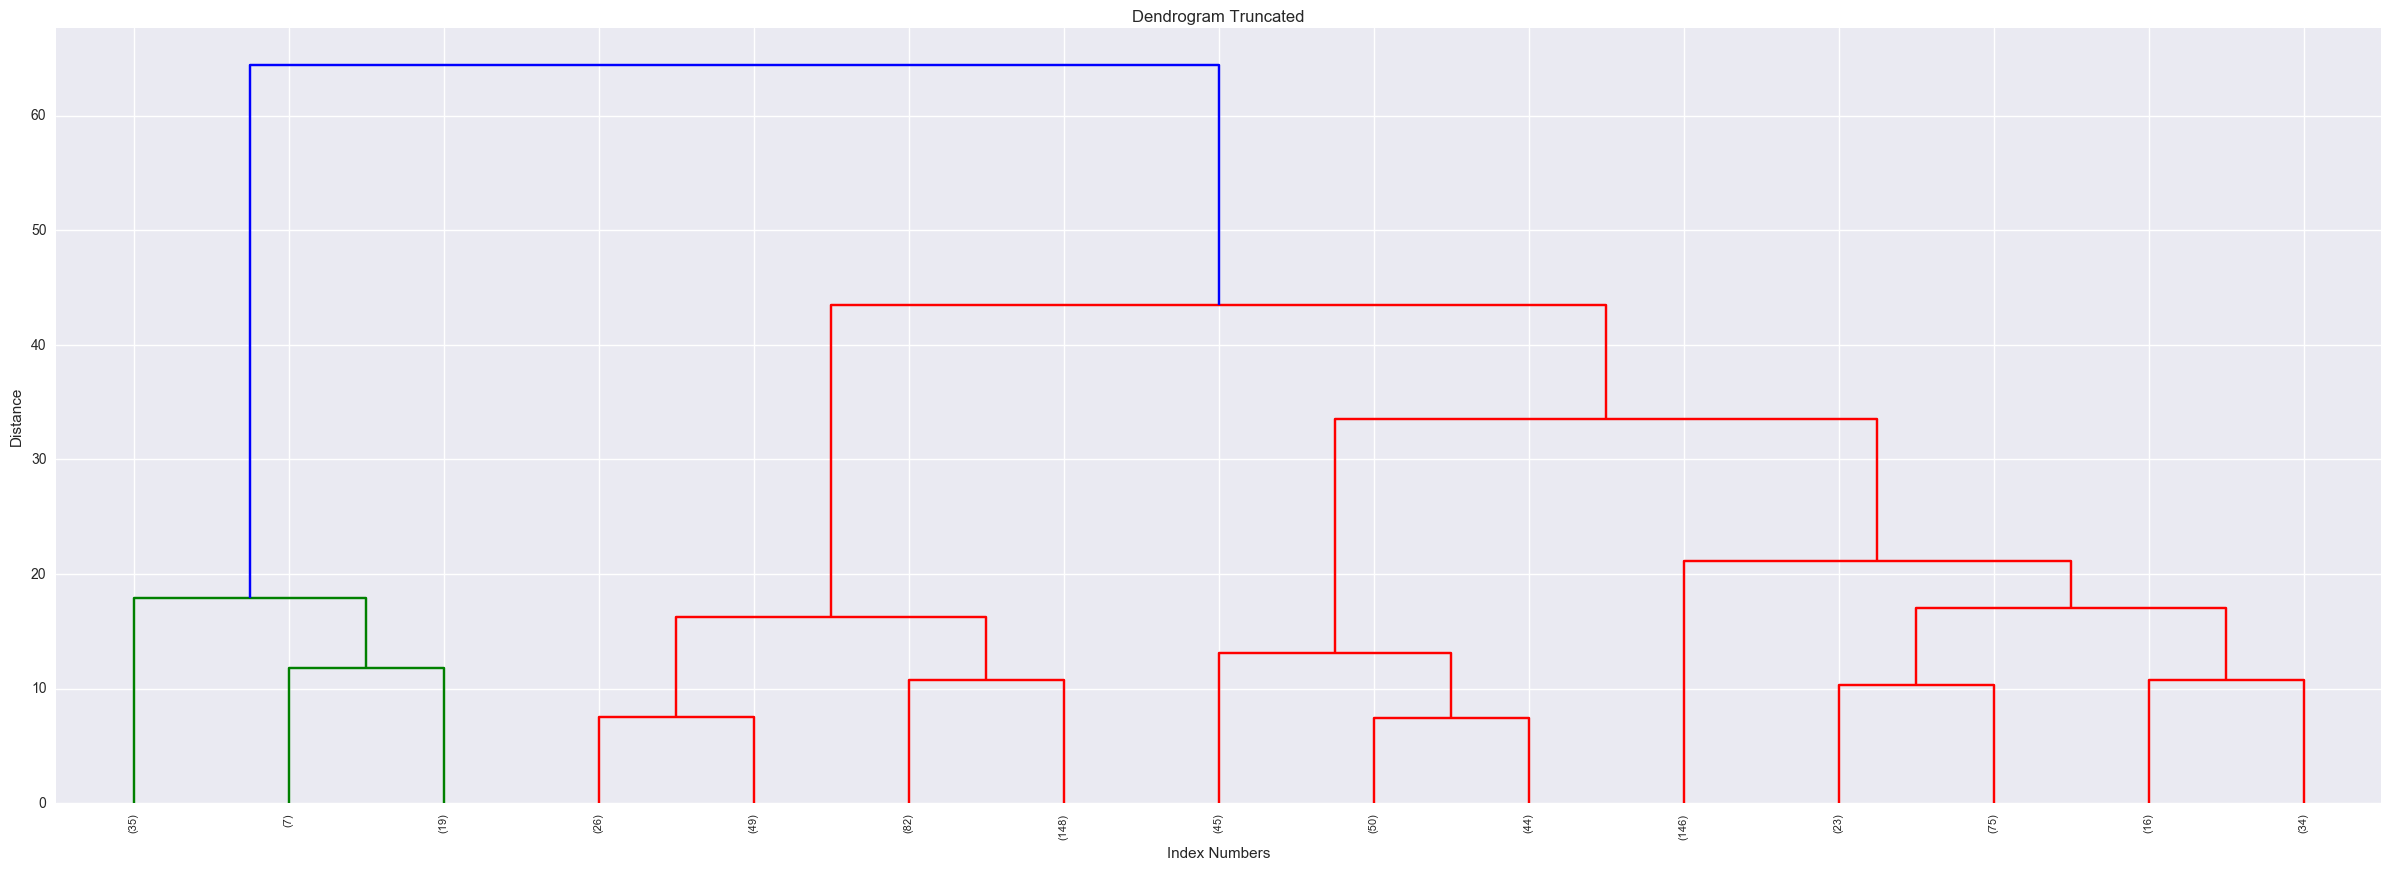

In [142]:
print " Cophenit coefficient:",c
plt.figure(figsize=(30, 10))
plt.title('Dendrogram Truncated')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z, truncate_mode='lastp',p=15,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

Cophenet coefficient is good which is reflect a certain stability of our model

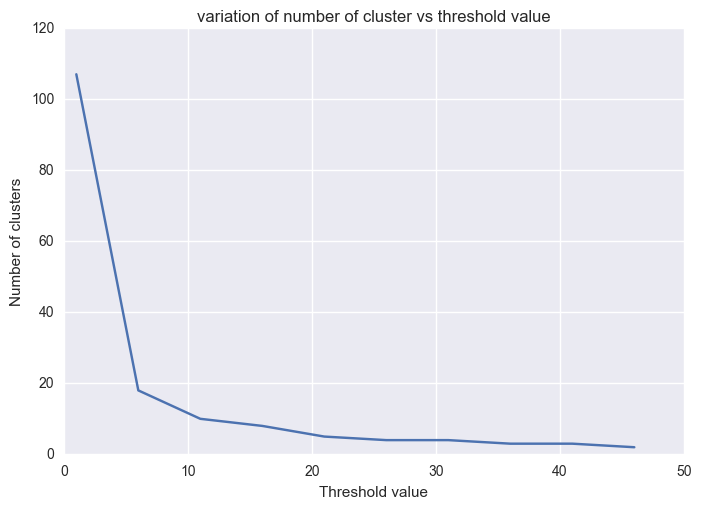

In [147]:
# let's try to see the number of cluster in function of the threshold

num_cluster=[]
for d in range(1,50,5):
    clusters = fcluster(Z, d, criterion='distance')
    num_cluster.append(len(np.unique(clusters)))

plt.plot(range(1,50,5),num_cluster)
plt.title("variation of number of cluster vs threshold value")
plt.xlabel("Threshold value")
plt.ylabel("Number of clusters")
plt.show()
print 

Hierarchical clustering result:
Number of cluster: 4
Clusters are defined as: [1 2 3 4]
whole year


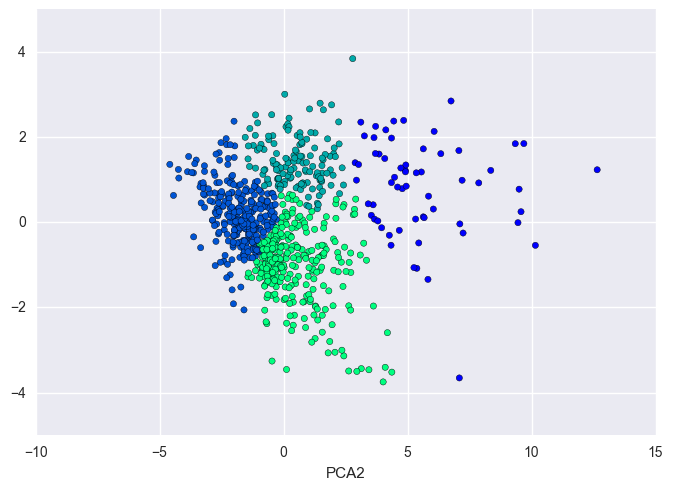

Over the year
Year: 2014


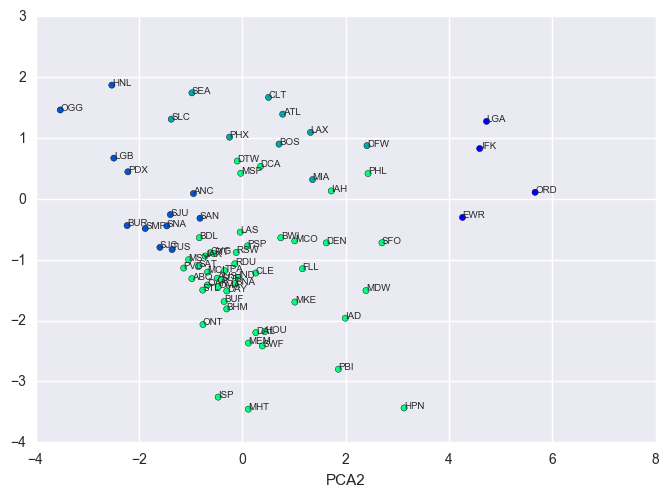

Year: 2013


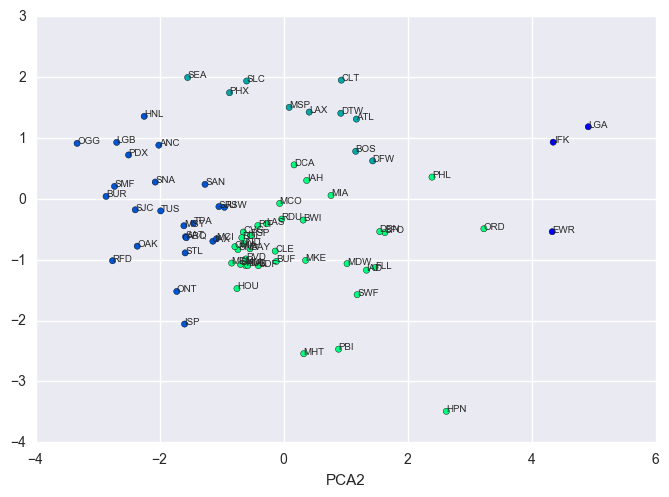

Year: 2012


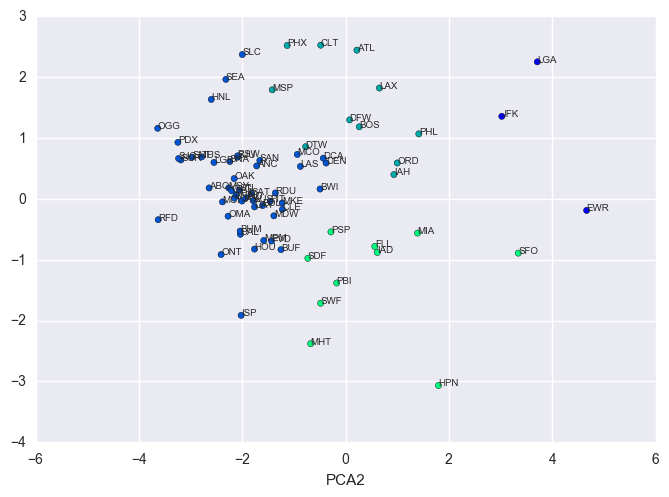

Year: 2011


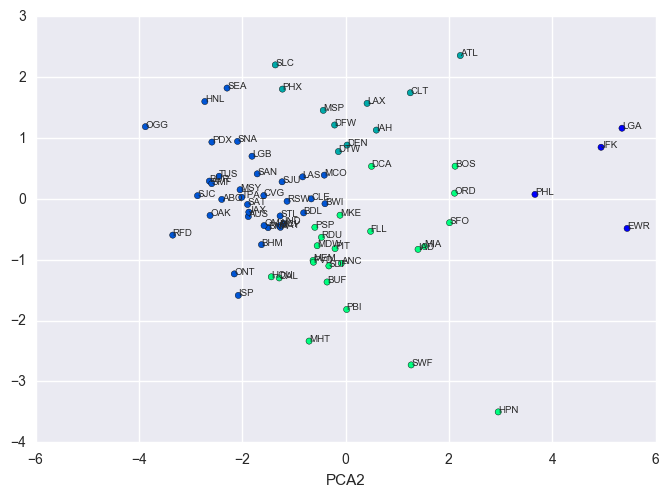

Year: 2010


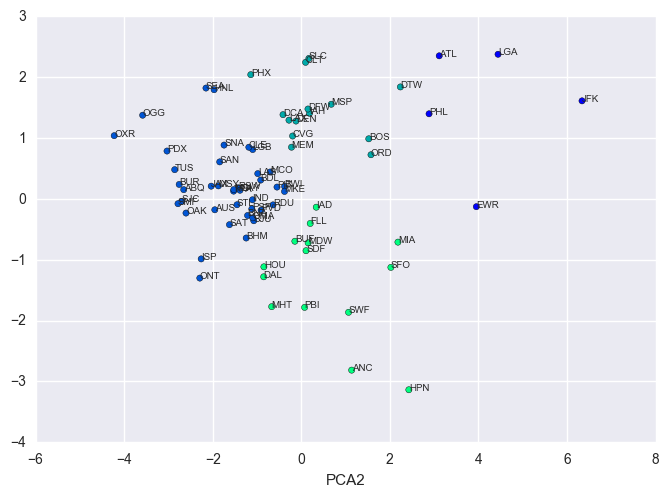

Year: 2009


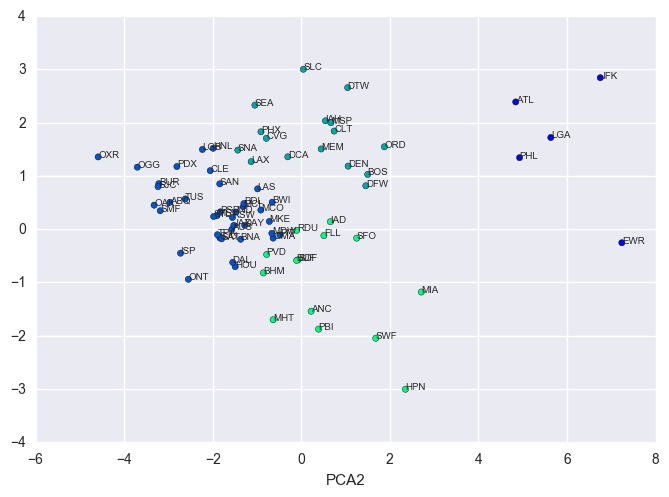

Year: 2008


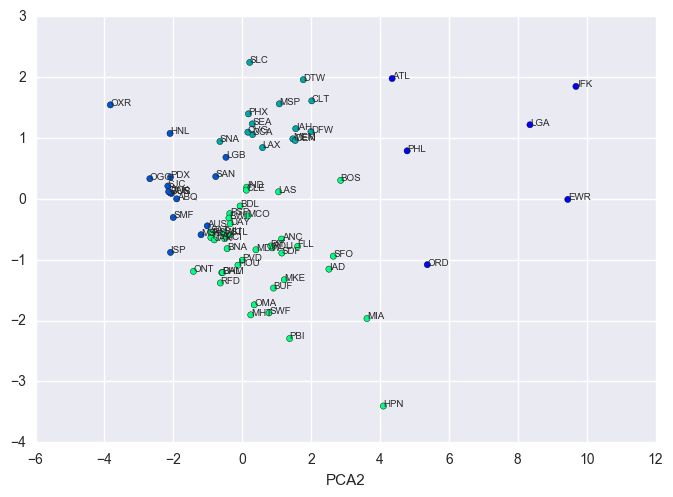

Year: 2007


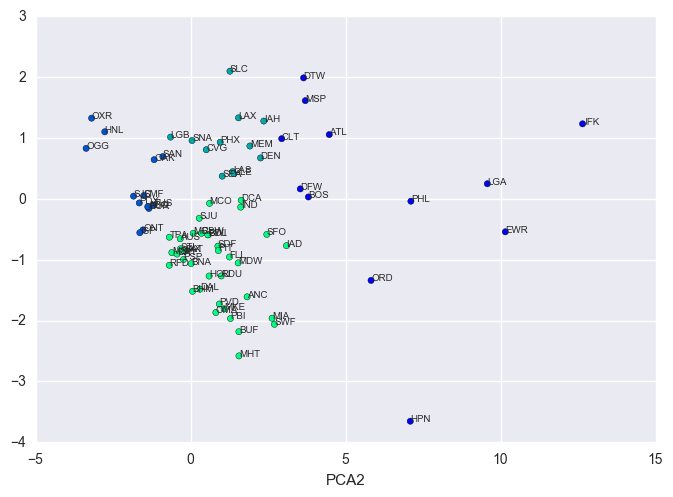

Year: 2006


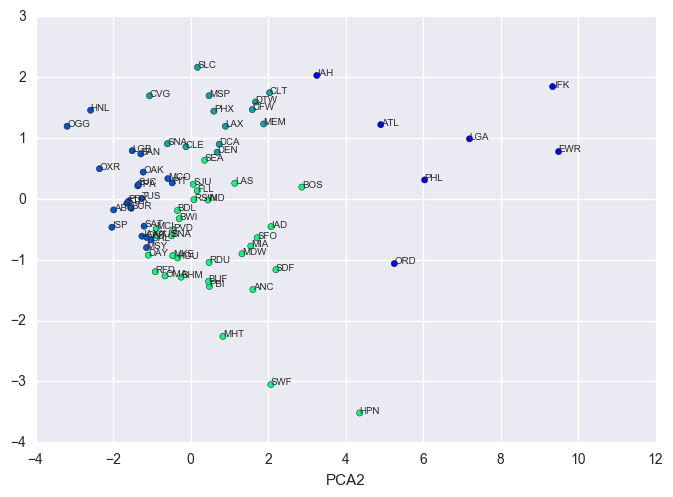

Year: 2005


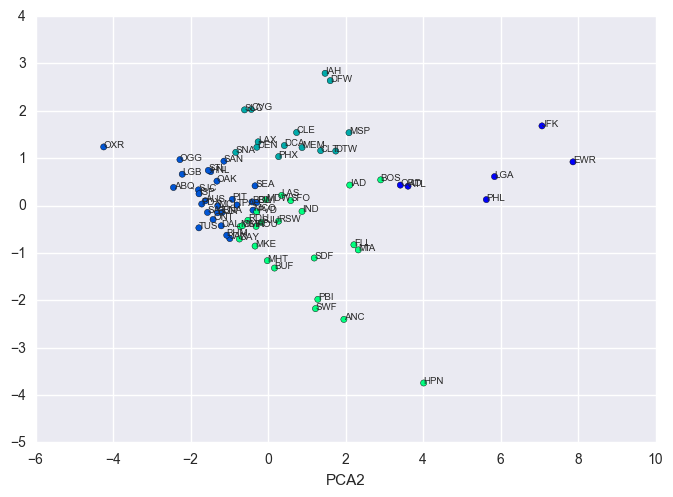

Year: 2004


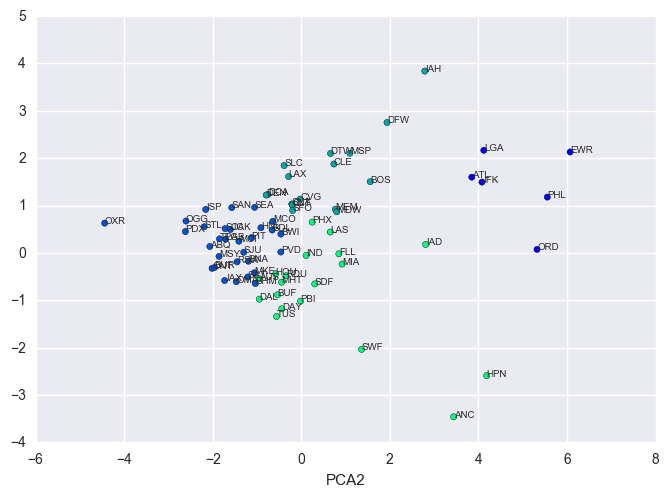

In [208]:
# from those 2 graph belows it seems our data to be separated in 4 clusters.
# let's try to drox our 4 cluster in function of Kmean, dbscan and hierarchical clustering result over the year.

xred2=Xred.copy()
xred2["airport"]=ap["airport"]
xred2["airport_qualification"]=ap["airport_qualification"]
xred2["FAA region"]=ap["FAA REGION"]
xred2["year"]=ap["year"]


print "Hierarchical clustering result:"
clusters = fcluster(Z, 30, criterion='distance')
print "Number of cluster:",len(np.unique(clusters))
print "Clusters are defined as:",np.unique(clusters)
xred2_h=xred2.copy()
xred2_h["label"]=clusters

year=ap.year.unique()

print "whole year"
plt.scatter(xred2_h[["PCA1"]],xred2_h[["PCA2"]],c=xred2_h[["label"]],cmap='winter')
plt.xlabel("PCA1")
plt.xlabel("PCA2")
plt.show()

print "Over the year"
for y in year:
    print "Year:",y
    xyear=xred2_h.loc[xred2_h["year"]==y,:]
    xyear.reset_index(inplace=True,drop=True)
    plt.scatter(xyear[["PCA1"]],xyear[["PCA2"]],c=xyear[["label"]],cmap='winter')
    plt.xlabel("PCA1")
    plt.xlabel("PCA2")
    for i, txt in enumerate(xyear["airport"]):
        (xi,yi)=(xyear.loc[i,"PCA1"],xyear.loc[i,"PCA2"])
        plt.annotate(txt, (xi,yi),fontsize=7)
    plt.show()


We have a nice separation, if we look over the year it correspond to the same airport inside the same cluster.

Density Based clustering result:
Number of cluster: 4
Clusters are defined as: [0 1 2 3]
whole year


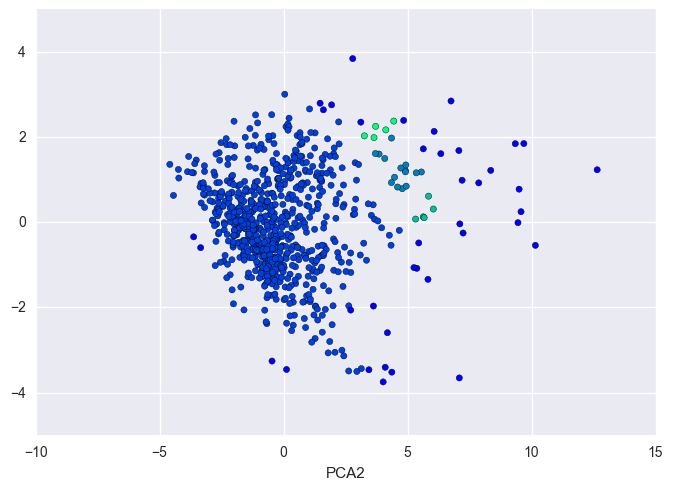

Over the year
Year: 2014


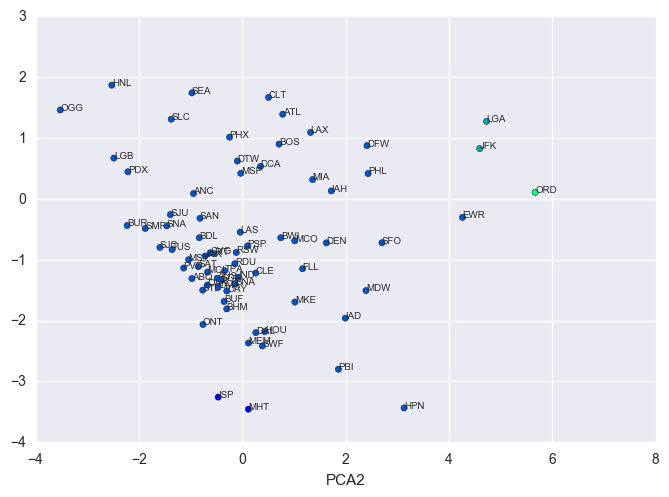

Year: 2013


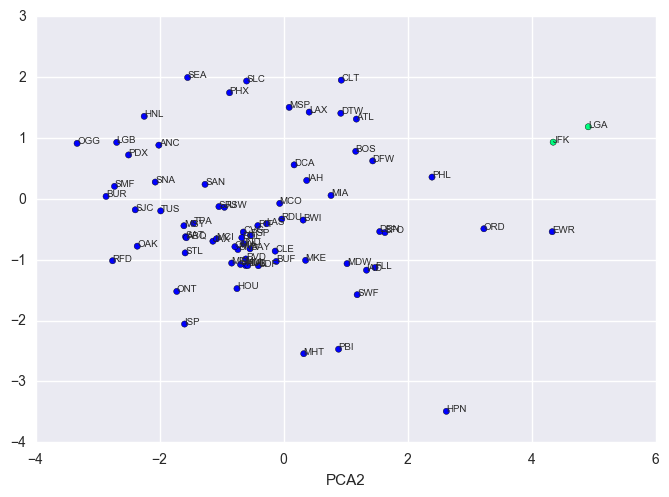

Year: 2012


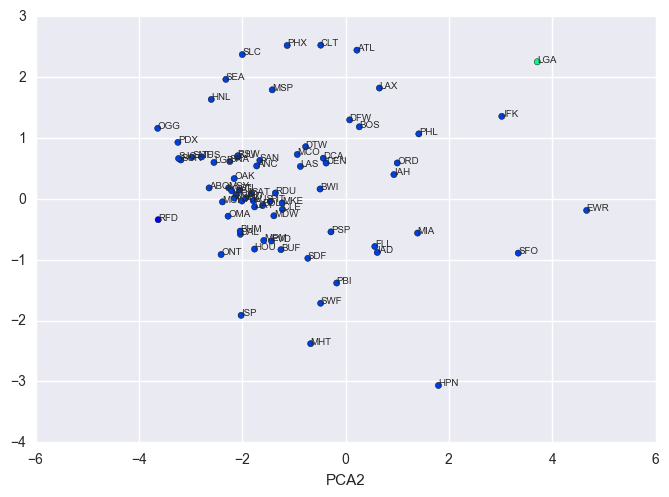

Year: 2011


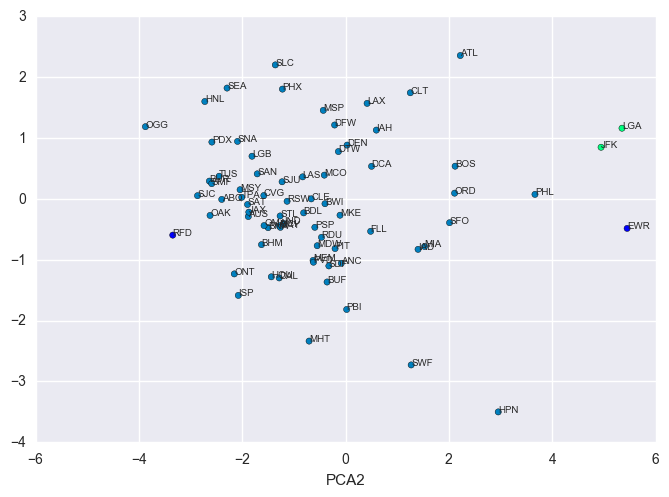

Year: 2010


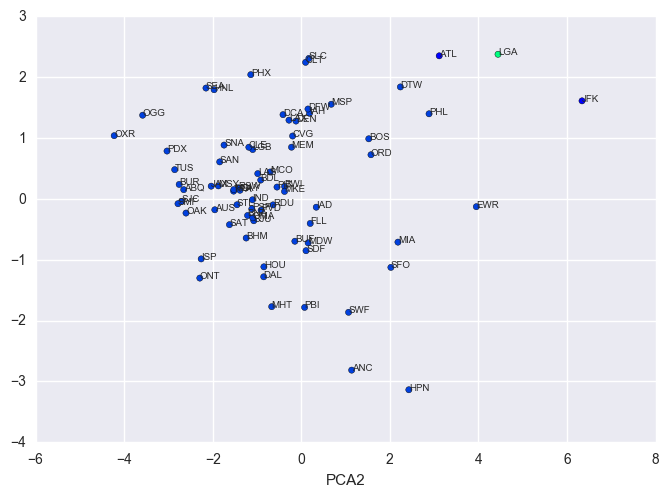

Year: 2009


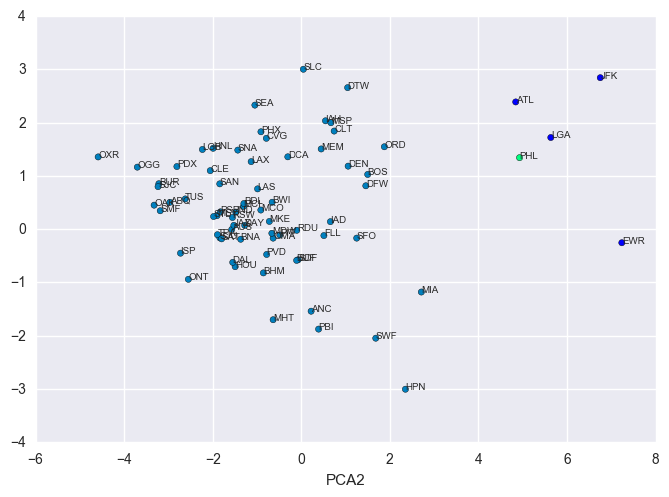

Year: 2008


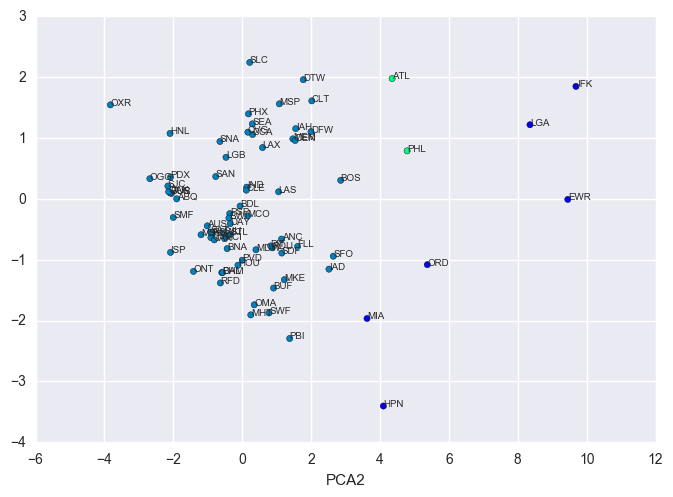

Year: 2007


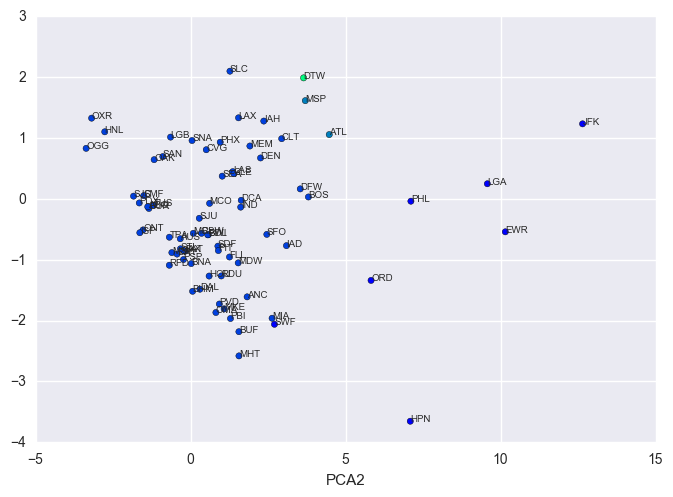

Year: 2006


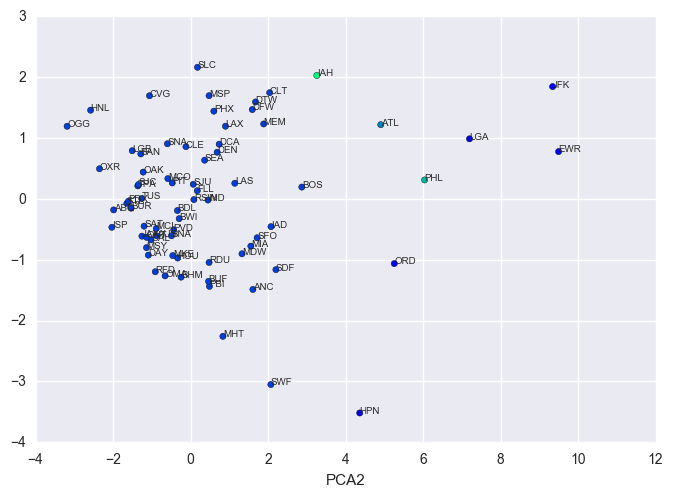

Year: 2005


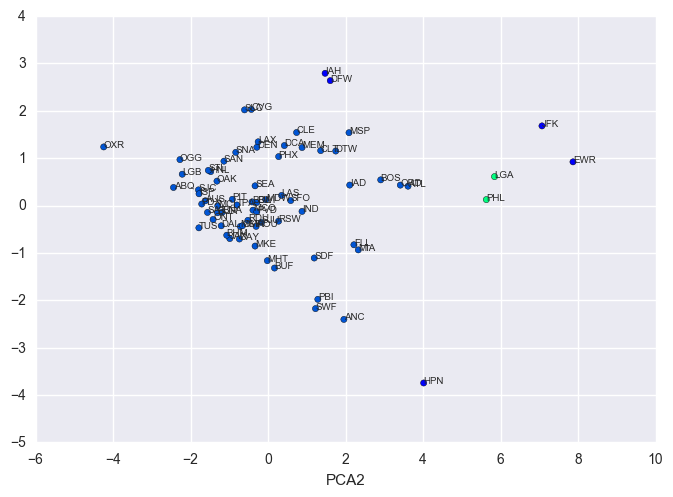

Year: 2004


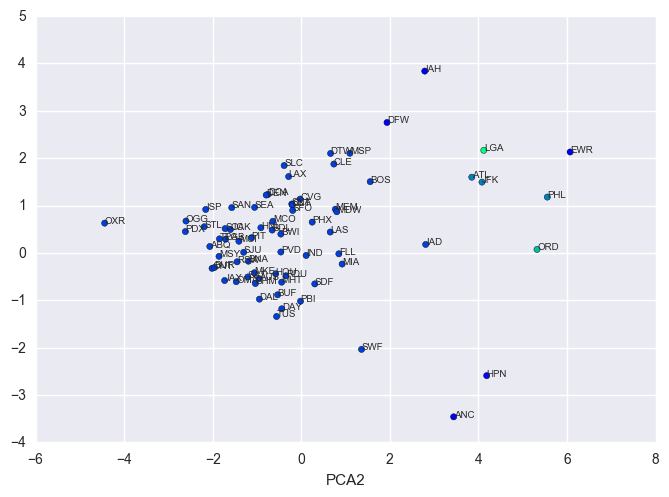

In [218]:
print "Density Based clustering result:"

db = DBSCAN(eps=0.6, min_samples=5)  
# do the fit
db.fit(Xred) 

clusters = db.labels_
print "Number of cluster:",len(np.unique(clusters))-1
print "Clusters are defined as:",np.unique(clusters)[1:]
xred2_db=xred2.copy()
xred2_db["label"]=clusters

year=ap.year.unique()

print "whole year"
plt.scatter(xred2_db[["PCA1"]],xred2_db[["PCA2"]],c=xred2_db[["label"]],cmap='winter')
plt.xlabel("PCA1")
plt.xlabel("PCA2")
plt.show()

print "Over the year"
for y in year:
    print "Year:",y
    xyear=xred2_db.loc[xred2_db["year"]==y,:]
    xyear.reset_index(inplace=True,drop=True)
    plt.scatter(xyear[["PCA1"]],xyear[["PCA2"]],c=xyear[["label"]],cmap='winter')
    plt.xlabel("PCA1")
    plt.xlabel("PCA2")
    for i, txt in enumerate(xyear["airport"]):
        (xi,yi)=(xyear.loc[i,"PCA1"],xyear.loc[i,"PCA2"])
        plt.annotate(txt, (xi,yi),fontsize=7)
    plt.show()

That time, It is really not clear which airport are in the cluster compared to the hierarichical clustering.

 Kmean result:
Number of cluster: 3
Clusters are defined as: [1 2 3]
Silhouette score: 0.393067458703
whole year


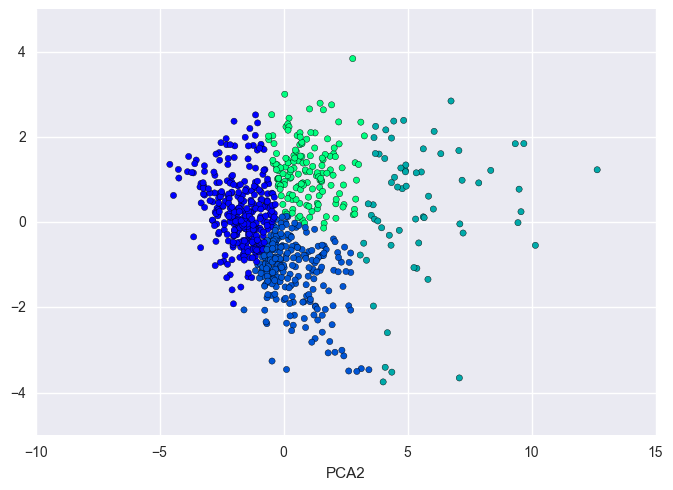

Over the year
Year: 2014


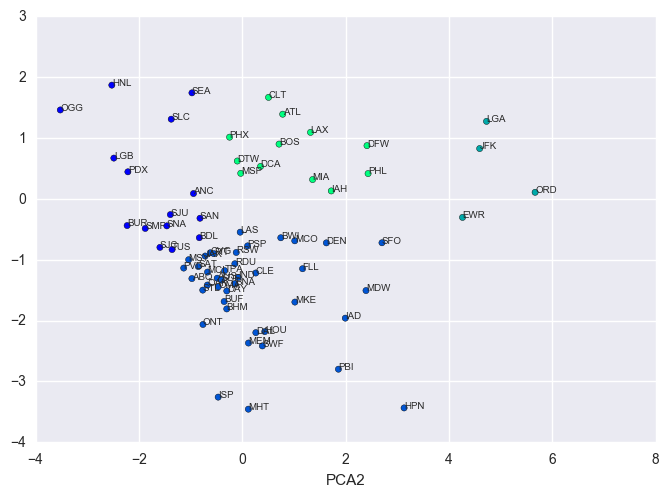

Year: 2013


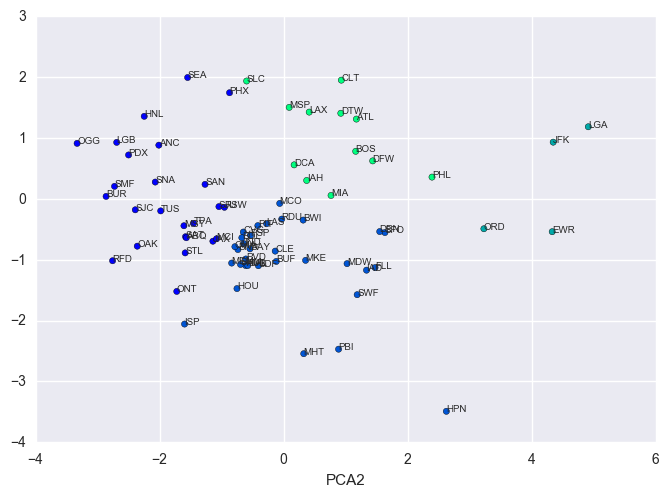

Year: 2012


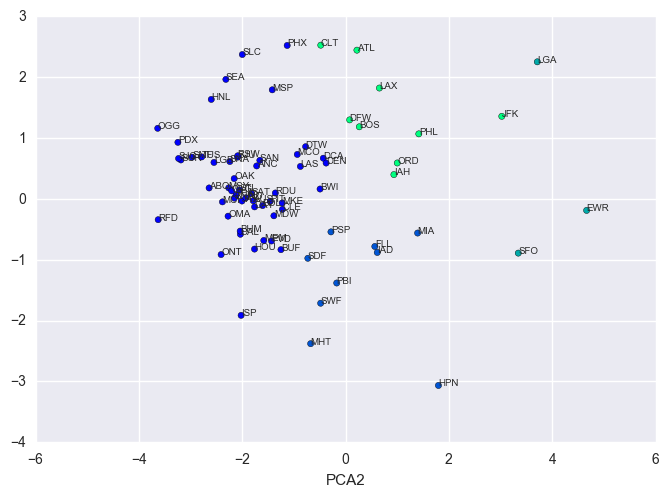

Year: 2011


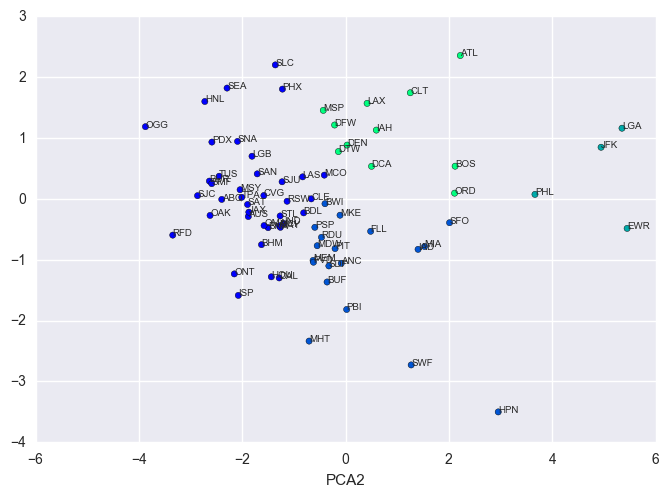

Year: 2010


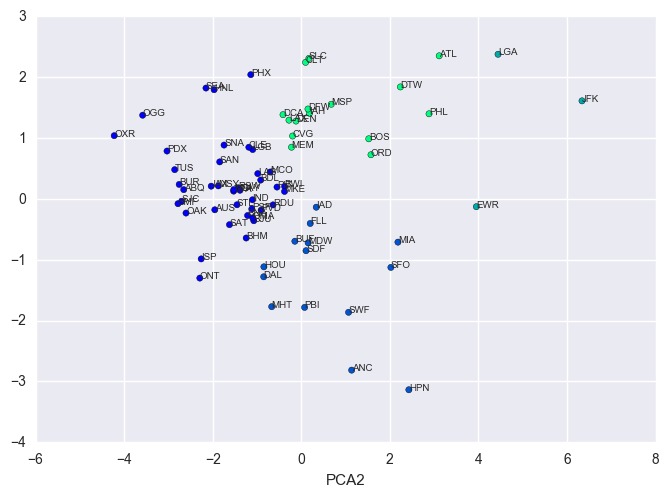

Year: 2009


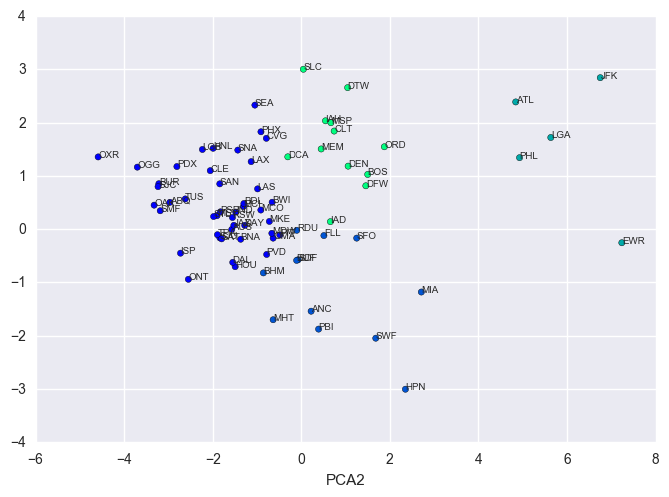

Year: 2008


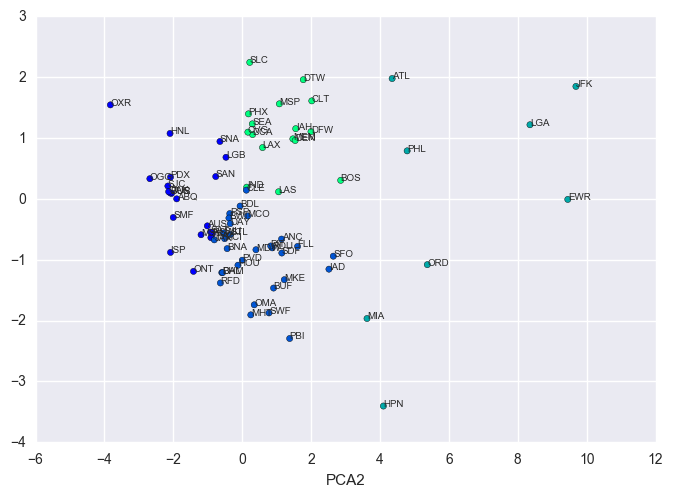

Year: 2007


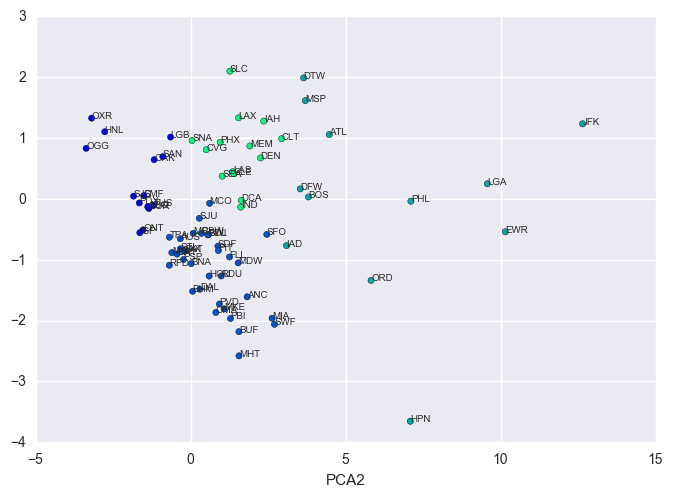

Year: 2006


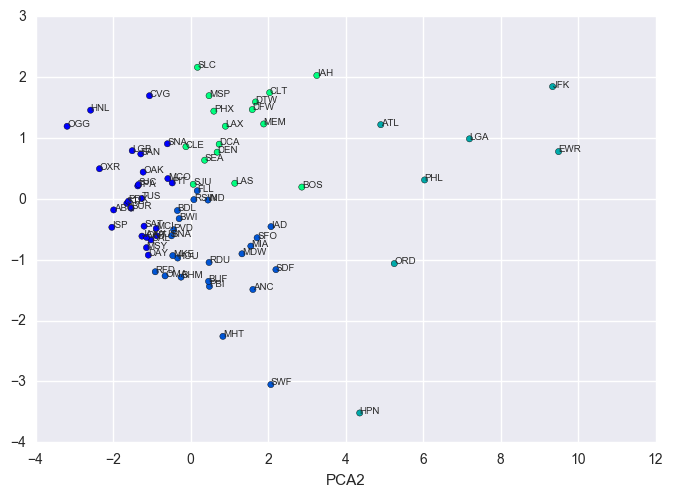

Year: 2005


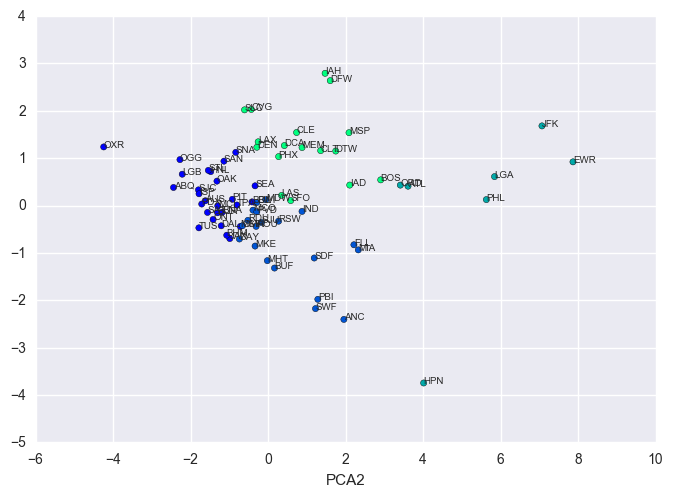

Year: 2004


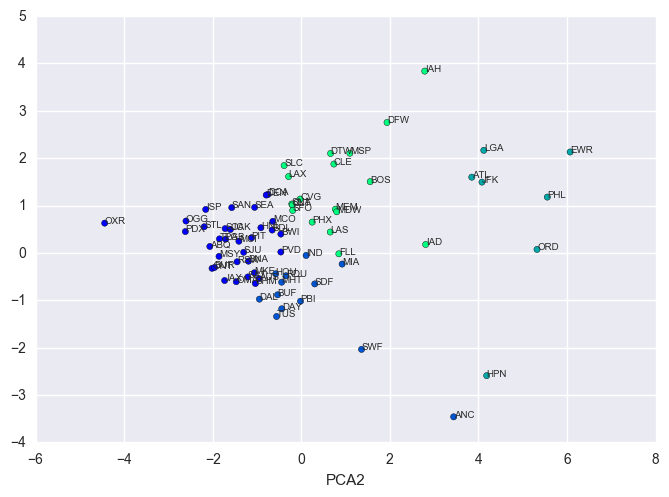

In [220]:
from sklearn import metrics
print "Kmean result:"

km = KMeans(n_clusters=4,random_state=1)  
# do the fit
km.fit(Xred) 

clusters = km.labels_
print "Number of cluster:",len(np.unique(clusters))-1
print "Clusters are defined as:",np.unique(clusters)[1:]
print "Silhouette score:", metrics.silhouette_score(Xred, km.labels_, metric='euclidean')
xred2_km=xred2.copy()
xred2_km["label"]=clusters

year=ap.year.unique()

print "whole year"
plt.scatter(xred2_km[["PCA1"]],xred2_km[["PCA2"]],c=xred2_km[["label"]],cmap='winter')
plt.xlabel("PCA1")
plt.xlabel("PCA2")
plt.show()

print "Over the year"
for y in year:
    print "Year:",y
    xyear=xred2_km.loc[xred2_km["year"]==y,:]
    xyear.reset_index(inplace=True,drop=True)
    plt.scatter(xyear[["PCA1"]],xyear[["PCA2"]],c=xyear[["label"]],cmap='winter')
    plt.xlabel("PCA1")
    plt.xlabel("PCA2")
    for i, txt in enumerate(xyear["airport"]):
        (xi,yi)=(xyear.loc[i,"PCA1"],xyear.loc[i,"PCA2"])
        plt.annotate(txt, (xi,yi),fontsize=7)
    plt.show()

The result is better than hierarchical clustering although it is less stable, airport are changing cluster over the year.
But, this can be a result of an improvment in some way.

#### 5.2 Write an analysis plan of your findings 

**Conclusion**

In that study, we first need to create a local database to manage to join dataset coming from different sources.
As per our exploratory analysis, we pointed out that the quality service in term of delay and cancelation is not improving over 10 past years although any type of airport faced a little diminution in the flow of flights.  
We also noticed that some information can be predicted regarding the size of an airport like for example, arrival and departure cancelation which seems to follown a linear regression model.  
But in another way, notably regarding delay, it is difficult to apply any prediction as it seems that there is no correlation with size or FAA regions.  
I then decided, after performing a principal component analysis over the delay dataset, to apply clustering technics so that to draw the frontiere of some clusters.
It seems to have 4 clusters in our dataset, which has been weel higlighted by the hierarchical clustering method.  
The idea is now to try to study more closely cluster by cluster, what make them remaining in that cluster, and also, regarding the kmeans model, what make them changing cluster.
This will to help to predict evolution of an airport activity and/or enable operational quality team to focus on cluster creating more issues.